# MPRA regression of background samples with K-fold cross validation

### Library imports


In [2]:
import os 
import getopt
import sys

import random
import re

import numpy as np
import h5py
import pickle
import random
import copy
import pandas as pd
import math 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Masking, Lambda, concatenate, Bidirectional, Dense, Dropout, Flatten, Conv1D,BatchNormalization,  MaxPooling1D, Bidirectional, GRU, TimeDistributed
import tensorflow as tf
from tensorflow import keras



2023-11-03 15:28:56.354497: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-03 15:28:56.386474: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 15:28:56.386507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 15:28:56.386529: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 15:28:56.392971: I tensorflow/core/platform/cpu_feature_g

### Input ingestion

Here we define the methods to read and ingest data and we initialize the random seed.

Since we are processing the background the vocabulary is comprised of lower case nucleotides.

The upper cases (where the motif is), will be encoded as a zero-like vector

In [3]:
np.random.seed(1337) # for reproducibility

# Lower case vocabulary
vocab = ["a", "c", "g", "t"]
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets=1)

# These are the defaults of the data reader method 
# (each column in the ingested csv must be initialized with the right data type, otherwise the data ingestion fails )
defs = [0.] * 1 + [tf.constant([], dtype="string")] + [tf.constant([], dtype="string")]


def data_reader(file, batch_size=100, n_parse_threads=4):
    """Method for reading the data in an optimized way, can be used inside model.fit()
    
    Args:
        file (_type_): path to csv file
        batch_size (int, optional): _description_. Defaults to 100.
        n_parse_threads (int, optional): _description_. Defaults to 4.

    Returns:
        dataset.batch: batch dataset object 
    """
    dataset = tf.data.TextLineDataset(file).skip(1)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    return dataset.batch(batch_size).prefetch(1)

def preprocess(record):
    """Preprocessing method of a dataset object, one-hot-encodes the data

    Args:
        record (_type_): _description_

    Returns:
        X (2D np.array): one-hot-encoded input sequence
        Y (1D np.array): MPRA measurements

    """
    # Extract fields from passed batch
    fields = tf.io.decode_csv(record, record_defaults=defs)
    chars = tf.strings.bytes_split(fields[1])     # Extract sequences from 1st field
    chars_indices = table.lookup(chars)     # one-hot-encoding
    
    # Create a mask for out-of-vocabulary characters
    oov_mask = tf.equal(chars_indices, len(vocab))
    
    # Explicitly cast the value to int64
    chars_indices = tf.where(oov_mask, tf.constant(len(vocab), dtype=tf.int64), chars_indices)
    
    X = tf.one_hot(chars_indices, depth=len(vocab))
    Y = fields[0]
    return X, Y


2023-11-03 15:28:57.899946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20011 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6


### Randomization of motif sequences and data augmentation

This chunk defines a function that takes a dataframe with sequences and replaces upper case characters with random sequences N times

In [4]:
def randomize_motifs_and_augment(df, num_augmentations=100):
    """This methods takes a dataframe containing a 'seq' column, randomizes the upper case characters and augments this sequences n times

    Args:
        df (pd.DataFrame): dataframe containing a 'seq' column
        num_augmentations (int, optional): Number of random sequences to obtaining for each input sequence. Defaults to 100.

    Returns:
        df (pd.DataFrame): df with an additional 'rnd_seq' column containing randomized upper case sequences, each sequence has N augmentation additional rows.
    """
    augmented_sequences = []

    for sequence in df['seq']:
        for _ in range(num_augmentations):
            random_sequence = ''.join(random.choice("ACGT") if char.isupper() else char for char in sequence)
            augmented_sequences.append(random_sequence)

    augmented_df = pd.DataFrame({'rnd_seq': augmented_sequences})
    df = df.loc[df.index.repeat(num_augmentations)].reset_index(drop=True)
    df = pd.concat([df, augmented_df], axis=1)
    return df

# Example data frame with DNA sequences

# test dataframe
data = {'seq': ["aaaACGTAGGCTA", "tttTTACGGTACACGT", "cccCGTACATACAGT"],
        'id' : ["1a", "2a", "3a"]}
df = pd.DataFrame(data)

# Call the randomize_motifs_and_augment function
result_df = randomize_motifs_and_augment(df, num_augmentations=3)

# Display the resulting data frame
result_df

,seq,id,rnd_seq
0,aaaACGTAGGCTA,1a,aaaTGGGTCTATA
1,aaaACGTAGGCTA,1a,aaaGGTCCTATCC
2,aaaACGTAGGCTA,1a,aaaGCCATGAATT
3,tttTTACGGTACACGT,2a,tttATCTATTCAAGGA
4,tttTTACGGTACACGT,2a,tttATCGCACCCCTAT
5,tttTTACGGTACACGT,2a,tttCGTTAAAGCGATG
6,cccCGTACATACAGT,3a,cccACCACGCGACAC
7,cccCGTACATACAGT,3a,cccGGGAGGGAATTT
8,cccCGTACATACAGT,3a,cccCTAAGACCGTCT


### k-fold cross validation split
Here we take the initial csv file and we split it in 3 partitions k times

It is possible to randomize the sequences and augment, since the masking of the model motifs was a better choice
for understanding the background this strategy is here commented out and not used


In [5]:
# CROSS VALIDATION (10 fold)
from sklearn.model_selection import train_test_split, KFold

whole_data = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/no_upper_LibA_wide_pivot_state3.csv"
out_data = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/"
# Split the data in two partitions
whole_data = pd.read_csv(whole_data)
k = 10
kf = KFold(n_splits = k, shuffle = True, random_state = 2008)

o=1
# For each fold we split again to get the third partition
for i in kf.split(whole_data):
    
    # Extract data from fold
    train = whole_data.iloc[i[0]]
    test =  whole_data.iloc[i[1]]
    
    # Split into train, validation and test
    valid, validation = train_test_split(train, test_size=0.111, random_state=42)
    
    # Randomize motifs
    #train = randomize_motifs_and_augment(train, num_augmentations=100)
    #train["rnd_seq"] = train['rnd_seq'].str.lower() 
    #test = randomize_motifs_and_augment(test, num_augmentations=100)
    #test["rnd_seq"] = test['rnd_seq'].str.lower() 
    #validation = randomize_motifs_and_augment(validation, num_augmentations=100)
    #validation["rnd_seq"] = validation['rnd_seq'].str.lower() 
    
    train[["State_3E", "seq", "CRS"]].to_csv(out_data+"background_CV"+str(o)+"_LibA_wide_pivot_state3_train.csv", index=False)
    test[["State_3E", "seq", "CRS"]].to_csv(out_data+"background_CV"+str(o)+"_LibA_wide_pivot_state3_test.csv", index=False)
    validation[["State_3E", "seq", "CRS"]].to_csv(out_data+"background_CV"+str(o)+"_LibA_wide_pivot_state3_validation.csv", index=False)
    o+=1
    

### Masking motifs

Since we do not want to backpropagate through the masked values we apply a mask on them

The mask is applied on values one-hot-encoded as a zero-like vector

Here we test the behaviour of the mask method to make sure it not masking 0 contained in every vector

In [6]:
# Define the masking layer with mask_value=0
masking_layer = tf.keras.layers.Masking(mask_value=0.0)

# Example input tensor with shape (batch_size, sequence_length, vocab_size)
input_tensor = tf.constant([
    [[0, 0, 0, 0, 0], [1, 0, 0, 0, 0], [0, 0, 0, 1, 0]],
    [[0, 0, 0, 0, 1], [0, 0, 0, 0, 1], [0, 0, 0, 0, 0]]
], dtype=tf.float32)

# Apply the masking layer to the input tensor
masked_tensor = masking_layer(input_tensor)

print(masked_tensor)
masking_layer.compute_mask(input_tensor)

tf.Tensor(
[[[0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 1.]
  [0. 0. 0. 0. 0.]]], shape=(2, 3, 5), dtype=float32)


<tf.Tensor: shape=(2, 3), dtype=bool, numpy=
array([[False,  True,  True],
       [ True,  True, False]])>

### Deep Learning model

Here we run the model which is based on this paper : 

https://doi.org/10.1101/2023.03.05.531189

I have added a Normalization layer parametrized with two parameters. Here we define the custom layer, the method to compute pearson correlation and a plotting function

In [7]:
# Here we initialize the df where each fold test prediction will be appended to
# the list containing the correlations of each fold is also initialized
df_test_10folds  = pd.DataFrame(columns=['State_3E', "seq", "prediction"])
corr_list = []

# We define a custom normalization layer to then compile on the model
class CustomNormalization(Layer):
    """Custom normalization layer that normalizes the output of the neural network"""
    def __init__(self, **kwargs):
        super(CustomNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Add trainable variables for mean and standard deviation
        self.mean = self.add_weight("mean", shape=(1,), initializer="zeros", trainable=True)
        self.stddev = self.add_weight("stddev", shape=(1,), initializer="ones", trainable=True)
        super(CustomNormalization, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        # Normalize the inputs using the learned mean and standard deviation
        return (inputs - self.mean) / (self.stddev + 1e-8)

# We define the method to compute the pearson correlation between prediction and ground truth
def pearson_correlation(x, y):
    """Computes Pearson Correlation between x and y
    Args:
        x (np.array): vector of predictions values
        y (np.array): vector of ground truth values

    Returns:
        (float): pearson correlation
    """
    n = len(x)
    
    # Calculate the mean of x and y
    mean_x = sum(x) / n
    mean_y = sum(y) / n
    
    # Calculate the numerator and denominators of the correlation coefficient
    numerator = sum((xi - mean_x) * (yi - mean_y) for xi, yi in zip(x, y))
    denominator_x = math.sqrt(sum((xi - mean_x) ** 2 for xi in x))
    denominator_y = math.sqrt(sum((yi - mean_y) ** 2 for yi in y))
    
    # Calculate the correlation coefficient
    correlation = numerator / (denominator_x * denominator_y)
    return correlation

import matplotlib.pyplot as plt
%matplotlib inline
# Define plotting function of loss
def create_plots(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.clf()

#### Model training
Here we iterate through the folds and train the model

In [8]:
df_test_10folds  = pd.DataFrame()
corr_list = []

for i in range(1,11):
    #Define inputs
    input_path_train = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_CV"+str(i)+"_LibA_wide_pivot_state3_train.csv"
    input_path_valid = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_CV"+str(i)+"_LibA_wide_pivot_state3_validation.csv"
    input_path_test = "/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/background_CV"+str(i)+"_LibA_wide_pivot_state3_test.csv"
   
    df_test = pd.read_csv(input_path_test)
    df_test["fold"] = str(i)
    corr_per_iteration = []
    # Get first item of the dataset to get the shape of the input data
    for element in data_reader(input_path_train):
        input_shape = element[0].shape
        
    for iteration in range(1,11):
        inputs = Input(shape=(input_shape[1],input_shape[2]), name="inputs")
        inputs = Masking()(inputs)
        layer = Conv1D(250, kernel_size=7, strides=1, activation='relu', name="conv1")(inputs)  # 250 7 relu
        layer = Dropout(0.3)(layer)
        layer = BatchNormalization()(layer)
        layer = Conv1D(250, 8, strides=1, activation='softmax', name="conv2")(layer)  # 250 8 softmax
        layer = BatchNormalization()(layer)
        layer = MaxPooling1D(pool_size=2, strides=None, name="maxpool1")(layer)
        layer = Dropout(0.3)(layer)
        layer = Conv1D(250, 3, strides=1, activation='softmax', name="conv3")(layer)  # 250 3 softmax
        layer = BatchNormalization()(layer)
        layer = Dropout(0.3)(layer)
        layer = Conv1D(100, 2, strides=1, activation='softmax', name="conv4")(layer)  # 100 3 softmax
        layer = BatchNormalization()(layer)
        layer = MaxPooling1D(pool_size=1, strides=None, name="maxpool2")(layer)
        layer = Dropout(0.3)(layer)
        layer = Flatten()(layer)
        layer = Dense(300, activation='sigmoid')(layer)  # 300
        layer = Dropout(0.3)(layer)
        layer = Dense(200, activation='sigmoid')(layer)  # 300
        predictions = Dense(1, activation='linear')(layer)

        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer="adam",
                    loss="mean_squared_error",
                    metrics=["mse", "mae", "mape"],
                    )

        history=model.fit(data_reader(input_path_train, batch_size=100),
                                epochs=20,
                                validation_data=data_reader(input_path_valid,batch_size=100),
                                callbacks=None,
                                verbose=2)

        predicted = model.predict(data_reader(input_path_test,
                                                    batch_size=100))

        test_data = data_reader(input_path_test,batch_size=100)
        test_tensor = X = np.empty(shape=[0,1])
        for batch in test_data:
            test_tensor = np.append(test_tensor, batch[1])

        df_test["prediction_iteration_"+str(iteration)] = predicted
        
                
        corr_coefficient = pearson_correlation(predicted.flatten(), test_tensor)
        corr_per_iteration.append(corr_coefficient)
    
    df_test_10folds = pd.concat([df_test_10folds, df_test], ignore_index=True)    
        
    corr_ensemble = np.mean(corr_per_iteration)
    corr_list.append(corr_ensemble)

df_test_10folds.to_csv("/home/felix/cluster/fpacheco/Data/Robert_data/processed_data/10fold_cv/LibA_wide_pivot_state3_test_predicted_cv10fold_background_ensemble.csv", index=False)

Epoch 1/20


2023-11-03 15:29:04.599003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-03 15:29:04.637541: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 15:29:04.739555: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-03 15:29:06.084574: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fae78b51750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-03 15:29:06.084602: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-11-03 15:29:06.088789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-03 15:29:06.186892: I ./tensorflow/compiler/jit/device_comp

77/77 - 8s - loss: 0.0766 - mse: 0.0766 - mae: 0.2039 - mape: 46347.6484 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1918 - val_mape: 425.9448 - 8s/epoch - 97ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0568 - mse: 0.0568 - mae: 0.1732 - mape: 20139.8438 - val_loss: 0.0737 - val_mse: 0.0737 - val_mae: 0.2277 - val_mape: 584.9683 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0505 - mse: 0.0505 - mae: 0.1647 - mape: 11231.9531 - val_loss: 0.0703 - val_mse: 0.0703 - val_mae: 0.2204 - val_mape: 556.1211 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0458 - mse: 0.0458 - mae: 0.1592 - mape: 7338.1226 - val_loss: 0.0771 - val_mse: 0.0771 - val_mae: 0.2346 - val_mape: 611.5489 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0414 - mse: 0.0414 - mae: 0.1534 - mape: 11857.8369 - val_loss: 0.0514 - val_mse: 0.0514 - val_mae: 0.1717 - val_mape: 301.3326 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0370 - mse: 0.0370 - mae: 0.1452 - mape: 8010.9629 - val_loss: 0.

2023-11-03 15:29:42.477237: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0844 - mse: 0.0844 - mae: 0.2156 - mape: 53014.7148 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1629 - val_mape: 205.9924 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0577 - mse: 0.0577 - mae: 0.1747 - mape: 34533.5469 - val_loss: 0.0559 - val_mse: 0.0559 - val_mae: 0.1859 - val_mape: 393.9699 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0499 - mse: 0.0499 - mae: 0.1633 - mape: 16514.7031 - val_loss: 0.0581 - val_mse: 0.0581 - val_mae: 0.1920 - val_mape: 426.8821 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0462 - mse: 0.0462 - mae: 0.1592 - mape: 14749.7012 - val_loss: 0.0647 - val_mse: 0.0647 - val_mae: 0.2079 - val_mape: 503.1564 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0429 - mse: 0.0429 - mae: 0.1563 - mape: 14177.5322 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1952 - val_mape: 443.6943 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0368 - mse: 0.0368 - mae: 0.1440 - mape: 19373.6406 -

2023-11-03 15:30:19.712836: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 5s - loss: 0.0824 - mse: 0.0824 - mae: 0.2114 - mape: 75065.7344 - val_loss: 0.0548 - val_mse: 0.0548 - val_mae: 0.1827 - val_mape: 375.0588 - 5s/epoch - 59ms/step
Epoch 2/20


2023-11-03 15:30:24.714846: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:30:24.714918: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0574 - mse: 0.0574 - mae: 0.1752 - mape: 14400.9795 - val_loss: 0.0576 - val_mse: 0.0576 - val_mae: 0.1905 - val_mape: 419.1658 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0506 - mse: 0.0506 - mae: 0.1644 - mape: 3825.5713 - val_loss: 0.0601 - val_mse: 0.0601 - val_mae: 0.1969 - val_mape: 451.6707 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0455 - mse: 0.0455 - mae: 0.1584 - mape: 17736.6699 - val_loss: 0.0906 - val_mse: 0.0906 - val_mae: 0.2603 - val_mape: 705.0449 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0439 - mse: 0.0439 - mae: 0.1586 - mape: 5477.9736 - val_loss: 0.0504 - val_mse: 0.0504 - val_mae: 0.1657 - val_mape: 245.7776 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0374 - mse: 0.0374 - mae: 0.1460 - mape: 14636.6777 - val_loss: 0.1216 - val_mse: 0.1216 - val_mae: 0.3109 - val_mape: 875.4711 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0323 - mse: 0.0323 - mae: 0.1372 - mape: 24015.3262 - val_loss: 0.

2023-11-03 15:31:01.136168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:31:01.136258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0784 - mse: 0.0784 - mae: 0.2065 - mape: 11025.9863 - val_loss: 0.0673 - val_mse: 0.0673 - val_mae: 0.2138 - val_mape: 528.9837 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 15:31:01.526502: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:31:01.526575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0573 - mse: 0.0573 - mae: 0.1758 - mape: 10318.4395 - val_loss: 0.0667 - val_mse: 0.0667 - val_mae: 0.2124 - val_mape: 523.0028 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0505 - mse: 0.0505 - mae: 0.1646 - mape: 15995.0088 - val_loss: 0.0663 - val_mse: 0.0663 - val_mae: 0.2115 - val_mape: 519.1162 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0476 - mse: 0.0476 - mae: 0.1628 - mape: 15816.2158 - val_loss: 0.0532 - val_mse: 0.0532 - val_mae: 0.1778 - val_mape: 344.0112 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0404 - mse: 0.0404 - mae: 0.1506 - mape: 25540.4141 - val_loss: 0.1045 - val_mse: 0.1045 - val_mae: 0.2838 - val_mape: 786.3095 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0356 - mse: 0.0356 - mae: 0.1420 - mape: 15440.7021 - val_loss: 0.1347 - val_mse: 0.1347 - val_mae: 0.3298 - val_mape: 936.0529 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0337 - mse: 0.0337 - mae: 0.1396 - mape: 4093.1616 - val_loss: 0

2023-11-03 15:32:10.363302: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1477 - mse: 0.1477 - mae: 0.2702 - mape: 69634.4766 - val_loss: 0.0506 - val_mse: 0.0506 - val_mae: 0.1664 - val_mape: 250.6494 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0609 - mse: 0.0609 - mae: 0.1807 - mape: 33136.3750 - val_loss: 0.0509 - val_mse: 0.0509 - val_mae: 0.1617 - val_mape: 182.5984 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0546 - mse: 0.0546 - mae: 0.1718 - mape: 12273.1406 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1623 - val_mape: 119.0990 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0477 - mse: 0.0477 - mae: 0.1616 - mape: 7431.4927 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1628 - val_mape: 205.0294 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0424 - mse: 0.0424 - mae: 0.1546 - mape: 6225.2524 - val_loss: 0.0507 - val_mse: 0.0507 - val_mae: 0.1617 - val_mape: 185.8173 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0381 - mse: 0.0381 - mae: 0.1471 - mape: 46413.5312 - v

2023-11-03 15:32:47.519342: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:32:52.488004: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:32:52.488095: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 5s - loss: 0.0864 - mse: 0.0864 - mae: 0.2172 - mape: 19082.2344 - val_loss: 0.0508 - val_mse: 0.0508 - val_mae: 0.1620 - val_mape: 188.9684 - 5s/epoch - 63ms/step
Epoch 2/20


2023-11-03 15:32:52.888653: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:32:52.888722: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0585 - mse: 0.0585 - mae: 0.1766 - mape: 3464.5723 - val_loss: 0.0523 - val_mse: 0.0523 - val_mae: 0.1749 - val_mape: 323.1586 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0521 - mse: 0.0521 - mae: 0.1667 - mape: 11502.6826 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1957 - val_mape: 445.8688 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0472 - mse: 0.0472 - mae: 0.1605 - mape: 8076.5405 - val_loss: 0.0636 - val_mse: 0.0636 - val_mae: 0.2054 - val_mape: 491.9044 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0429 - mse: 0.0429 - mae: 0.1542 - mape: 8463.5273 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1954 - val_mape: 444.6527 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0373 - mse: 0.0373 - mae: 0.1474 - mape: 13905.5791 - val_loss: 0.0522 - val_mse: 0.0522 - val_mae: 0.1604 - val_mape: 128.0875 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0383 - mse: 0.0383 - mae: 0.1489 - mape: 8968.2568 - val_loss: 0.09

2023-11-03 15:33:30.348222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:33:30.348293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0595 - mse: 0.0595 - mae: 0.1784 - mape: 15459.9248 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1651 - val_mape: 236.5855 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0526 - mse: 0.0526 - mae: 0.1693 - mape: 5627.7578 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1653 - val_mape: 238.3724 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0473 - mse: 0.0473 - mae: 0.1622 - mape: 6636.6870 - val_loss: 0.0520 - val_mse: 0.0520 - val_mae: 0.1613 - val_mape: 148.2975 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0417 - mse: 0.0417 - mae: 0.1536 - mape: 24243.1758 - val_loss: 0.0546 - val_mse: 0.0546 - val_mae: 0.1631 - val_mape: 108.0660 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0368 - mse: 0.0368 - mae: 0.1460 - mape: 32853.4219 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1669 - val_mape: 115.9078 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0336 - mse: 0.0336 - mae: 0.1403 - mape: 38872.1523 - val_loss: 0.

2023-11-03 15:34:02.528261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0800 - mse: 0.0800 - mae: 0.2087 - mape: 75648.9453 - val_loss: 0.0523 - val_mse: 0.0523 - val_mae: 0.1746 - val_mape: 321.3206 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 15:34:07.373776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:34:07.373850: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0565 - mse: 0.0565 - mae: 0.1733 - mape: 20897.3652 - val_loss: 0.0571 - val_mse: 0.0571 - val_mae: 0.1893 - val_mape: 412.6121 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0506 - mse: 0.0506 - mae: 0.1647 - mape: 24885.9316 - val_loss: 0.0601 - val_mse: 0.0601 - val_mae: 0.1971 - val_mape: 452.7171 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0444 - mse: 0.0444 - mae: 0.1551 - mape: 27320.0176 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.2201 - val_mape: 554.8614 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0403 - mse: 0.0403 - mae: 0.1515 - mape: 7815.0493 - val_loss: 0.0525 - val_mse: 0.0525 - val_mae: 0.1757 - val_mape: 330.9520 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0356 - mse: 0.0356 - mae: 0.1435 - mape: 19874.2148 - val_loss: 0.0514 - val_mse: 0.0514 - val_mae: 0.1736 - val_mape: 325.4372 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0337 - mse: 0.0337 - mae: 0.1399 - mape: 20906.6543 - val_loss: 0

2023-11-03 15:34:39.761055: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0779 - mse: 0.0779 - mae: 0.2061 - mape: 77188.3984 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1951 - val_mape: 442.3736 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0579 - mse: 0.0579 - mae: 0.1761 - mape: 24036.3359 - val_loss: 0.0646 - val_mse: 0.0646 - val_mae: 0.2077 - val_mape: 502.4180 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0510 - mse: 0.0510 - mae: 0.1649 - mape: 22379.4590 - val_loss: 0.0558 - val_mse: 0.0558 - val_mae: 0.1856 - val_mape: 392.1493 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0454 - mse: 0.0454 - mae: 0.1584 - mape: 4542.3560 - val_loss: 0.0505 - val_mse: 0.0505 - val_mae: 0.1658 - val_mape: 244.3049 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0411 - mse: 0.0411 - mae: 0.1510 - mape: 24339.9805 - val_loss: 0.0984 - val_mse: 0.0984 - val_mae: 0.2738 - val_mape: 752.6127 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0357 - mse: 0.0357 - mae: 0.1433 - mape: 10770.4453 - 

2023-11-03 15:35:22.449185: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:35:22.449293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 5s - loss: 0.1095 - mse: 0.1095 - mae: 0.2398 - mape: 60524.2969 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1810 - val_mape: 553.7206 - 5s/epoch - 63ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0613 - mse: 0.0613 - mae: 0.1802 - mape: 14494.6572 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1731 - val_mape: 371.7332 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0542 - mse: 0.0542 - mae: 0.1702 - mape: 6690.8042 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1747 - val_mape: 425.9762 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0477 - mse: 0.0477 - mae: 0.1610 - mape: 15358.8418 - val_loss: 0.0618 - val_mse: 0.0618 - val_mae: 0.1861 - val_mape: 624.1672 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0452 - mse: 0.0452 - mae: 0.1587 - mape: 20828.0625 - val_loss: 0.1027 - val_mse: 0.1027 - val_mae: 0.2732 - val_mape: 1326.5464 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0442 - mse: 0.0442 - mae: 0.1588 - mape: 26089.5059 - val_loss: 

2023-11-03 15:35:59.502336: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:35:59.502417: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.1456 - mse: 0.1456 - mae: 0.2657 - mape: 66487.9062 - val_loss: 0.0652 - val_mse: 0.0652 - val_mae: 0.1966 - val_mape: 743.5905 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0616 - mse: 0.0616 - mae: 0.1812 - mape: 13997.6973 - val_loss: 0.0619 - val_mse: 0.0619 - val_mae: 0.1864 - val_mape: 627.7347 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0551 - mse: 0.0551 - mae: 0.1724 - mape: 26599.5156 - val_loss: 0.0614 - val_mse: 0.0614 - val_mae: 0.1848 - val_mape: 607.4258 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0487 - mse: 0.0487 - mae: 0.1622 - mape: 25498.5508 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.1831 - val_mape: 584.1018 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0441 - mse: 0.0441 - mae: 0.1558 - mape: 15183.2705 - val_loss: 0.0675 - val_mse: 0.0675 - val_mae: 0.2030 - val_mape: 807.4296 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0384 - mse: 0.0384 - mae: 0.1479 - mape: 24981.6660 - val_loss: 

2023-11-03 15:36:37.020204: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:36:37.020273: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0588 - mse: 0.0588 - mae: 0.1762 - mape: 8214.3271 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1961 - val_mape: 738.4534 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0525 - mse: 0.0525 - mae: 0.1682 - mape: 28853.3418 - val_loss: 0.0644 - val_mse: 0.0644 - val_mae: 0.1944 - val_mape: 719.7132 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0464 - mse: 0.0464 - mae: 0.1599 - mape: 4224.0454 - val_loss: 0.0618 - val_mse: 0.0618 - val_mae: 0.1861 - val_mape: 623.4957 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0446 - mse: 0.0446 - mae: 0.1580 - mape: 35618.5586 - val_loss: 0.0619 - val_mse: 0.0619 - val_mae: 0.1870 - val_mape: 636.9457 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0365 - mse: 0.0365 - mae: 0.1442 - mape: 4639.8643 - val_loss: 0.0787 - val_mse: 0.0787 - val_mae: 0.2294 - val_mape: 1029.8219 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0323 - mse: 0.0323 - mae: 0.1376 - mape: 29394.0176 - val_loss: 0.

2023-11-03 15:37:09.494075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1519 - mse: 0.1519 - mae: 0.2707 - mape: 85945.5469 - val_loss: 0.0665 - val_mse: 0.0665 - val_mae: 0.2001 - val_mape: 778.6470 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 15:37:14.388019: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:37:14.388098: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0620 - mse: 0.0620 - mae: 0.1814 - mape: 37362.9297 - val_loss: 0.0630 - val_mse: 0.0630 - val_mae: 0.1903 - val_mape: 674.4581 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0554 - mse: 0.0554 - mae: 0.1732 - mape: 31569.6680 - val_loss: 0.0615 - val_mse: 0.0615 - val_mae: 0.1851 - val_mape: 611.3544 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0500 - mse: 0.0500 - mae: 0.1639 - mape: 22543.4746 - val_loss: 0.0644 - val_mse: 0.0644 - val_mae: 0.1943 - val_mape: 719.2699 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0444 - mse: 0.0444 - mae: 0.1567 - mape: 36650.7383 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2064 - val_mape: 838.4497 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0383 - mse: 0.0383 - mae: 0.1467 - mape: 14682.1689 - val_loss: 0.0782 - val_mse: 0.0782 - val_mae: 0.2278 - val_mape: 1017.0046 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0332 - mse: 0.0332 - mae: 0.1389 - mape: 5153.0049 - val_loss: 

2023-11-03 15:38:26.884503: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 5s - loss: 0.1190 - mse: 0.1190 - mae: 0.2466 - mape: 68191.7578 - val_loss: 0.0697 - val_mse: 0.0697 - val_mae: 0.2082 - val_mape: 854.5208 - 5s/epoch - 64ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0611 - mse: 0.0611 - mae: 0.1814 - mape: 33691.1602 - val_loss: 0.0621 - val_mse: 0.0621 - val_mae: 0.1873 - val_mape: 639.2054 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0550 - mse: 0.0550 - mae: 0.1721 - mape: 49354.3672 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1801 - val_mape: 538.5575 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0489 - mse: 0.0489 - mae: 0.1633 - mape: 36544.0469 - val_loss: 0.0608 - val_mse: 0.0608 - val_mae: 0.1825 - val_mape: 575.4886 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0434 - mse: 0.0434 - mae: 0.1556 - mape: 23701.2656 - val_loss: 0.0602 - val_mse: 0.0602 - val_mae: 0.1798 - val_mape: 537.0161 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0399 - mse: 0.0399 - mae: 0.1508 - mape: 27254.5391 - val_loss: 

2023-11-03 15:38:58.175877: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0887 - mse: 0.0887 - mae: 0.2203 - mape: 39575.8672 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.1725 - val_mape: 216.5706 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 15:39:02.916414: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0596 - mse: 0.0596 - mae: 0.1769 - mape: 24012.8828 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1923 - val_mape: 697.1981 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0522 - mse: 0.0522 - mae: 0.1674 - mape: 8393.8311 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1910 - val_mape: 682.1190 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0463 - mse: 0.0463 - mae: 0.1595 - mape: 19421.5352 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1783 - val_mape: 506.4252 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0419 - mse: 0.0419 - mae: 0.1533 - mape: 11851.3711 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1740 - val_mape: 413.3277 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0370 - mse: 0.0370 - mae: 0.1452 - mape: 15464.8525 - val_loss: 0.1158 - val_mse: 0.1158 - val_mae: 0.2948 - val_mape: 1459.0342 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0306 - mse: 0.0306 - mae: 0.1339 - mape: 8195.5225 - val_loss: 0

2023-11-03 15:39:33.506338: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:39:37.763193: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 4s - loss: 0.0822 - mse: 0.0822 - mae: 0.2138 - mape: 12666.1270 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.1805 - val_mape: 546.1840 - 4s/epoch - 54ms/step
Epoch 2/20


2023-11-03 15:39:38.098067: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0590 - mse: 0.0590 - mae: 0.1775 - mape: 12995.0605 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1930 - val_mape: 704.8724 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0513 - mse: 0.0513 - mae: 0.1673 - mape: 10316.6641 - val_loss: 0.0607 - val_mse: 0.0607 - val_mae: 0.1821 - val_mape: 569.1760 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0467 - mse: 0.0467 - mae: 0.1601 - mape: 4216.3428 - val_loss: 0.0616 - val_mse: 0.0616 - val_mae: 0.1722 - val_mape: 248.5715 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0410 - mse: 0.0410 - mae: 0.1511 - mape: 18294.8574 - val_loss: 0.0615 - val_mse: 0.0615 - val_mae: 0.1858 - val_mape: 622.8817 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0359 - mse: 0.0359 - mae: 0.1421 - mape: 5860.4893 - val_loss: 0.0916 - val_mse: 0.0916 - val_mae: 0.2546 - val_mape: 1209.1787 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0330 - mse: 0.0330 - mae: 0.1385 - mape: 15127.3975 - val_loss: 0

2023-11-03 15:40:13.086959: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:40:13.087064: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0774 - mse: 0.0774 - mae: 0.2061 - mape: 26177.8066 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1775 - val_mape: 490.7927 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0600 - mse: 0.0600 - mae: 0.1802 - mape: 35026.3320 - val_loss: 0.0607 - val_mse: 0.0607 - val_mae: 0.1817 - val_mape: 564.2013 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0536 - mse: 0.0536 - mae: 0.1708 - mape: 34763.8867 - val_loss: 0.0645 - val_mse: 0.0645 - val_mae: 0.1741 - val_mape: 159.4132 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0494 - mse: 0.0494 - mae: 0.1664 - mape: 6061.7881 - val_loss: 0.0718 - val_mse: 0.0718 - val_mae: 0.1839 - val_mape: 164.1041 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 1s - loss: 0.0439 - mse: 0.0439 - mae: 0.1578 - mape: 20452.6641 - val_loss: 0.0890 - val_mse: 0.0890 - val_mae: 0.2488 - val_mape: 1166.3787 - 1s/epoch - 19ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0374 - mse: 0.0374 - mae: 0.1456 - mape: 13744.6924 - val_loss: 

2023-11-03 15:40:48.036853: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:40:48.036945: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0760 - mse: 0.0760 - mae: 0.2030 - mape: 44995.4336 - val_loss: 0.0693 - val_mse: 0.0693 - val_mae: 0.2072 - val_mape: 845.7874 - 4s/epoch - 54ms/step
Epoch 2/20


2023-11-03 15:40:48.395393: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0604 - mse: 0.0604 - mae: 0.1811 - mape: 24004.9961 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1802 - val_mape: 540.9810 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0524 - mse: 0.0524 - mae: 0.1690 - mape: 17509.7461 - val_loss: 0.0596 - val_mse: 0.0596 - val_mae: 0.1743 - val_mape: 414.8216 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0472 - mse: 0.0472 - mae: 0.1606 - mape: 15352.2324 - val_loss: 0.0620 - val_mse: 0.0620 - val_mae: 0.1723 - val_mape: 233.2277 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0430 - mse: 0.0430 - mae: 0.1560 - mape: 29741.1504 - val_loss: 0.0784 - val_mse: 0.0784 - val_mae: 0.2280 - val_mape: 1017.3593 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0381 - mse: 0.0381 - mae: 0.1468 - mape: 24345.4824 - val_loss: 0.0960 - val_mse: 0.0960 - val_mae: 0.2628 - val_mape: 1262.1459 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0347 - mse: 0.0347 - mae: 0.1412 - mape: 13248.8008 - val_loss

2023-11-03 15:41:24.235955: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:41:24.236023: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.1348 - mse: 0.1348 - mae: 0.2581 - mape: 58355.6992 - val_loss: 0.0631 - val_mse: 0.0631 - val_mae: 0.1877 - val_mape: 409.5381 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 15:41:24.548794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 1s - loss: 0.0608 - mse: 0.0608 - mae: 0.1792 - mape: 29458.7520 - val_loss: 0.0612 - val_mse: 0.0612 - val_mae: 0.1813 - val_mape: 364.9319 - 1s/epoch - 19ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0550 - mse: 0.0550 - mae: 0.1715 - mape: 7795.3228 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1715 - val_mape: 277.4792 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0519 - mse: 0.0519 - mae: 0.1683 - mape: 9571.1650 - val_loss: 0.0700 - val_mse: 0.0700 - val_mae: 0.2065 - val_mape: 516.1135 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0702 - mse: 0.0702 - mae: 0.2026 - mape: 28604.2715 - val_loss: 0.0677 - val_mse: 0.0677 - val_mae: 0.2010 - val_mape: 486.8875 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0418 - mse: 0.0418 - mae: 0.1518 - mape: 11072.6865 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.2024 - val_mape: 497.6939 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0349 - mse: 0.0349 - mae: 0.1409 - mape: 31507.4395 - val_loss: 0.

2023-11-03 15:42:31.104397: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0802 - mse: 0.0802 - mae: 0.2099 - mape: 82334.2969 - val_loss: 0.0631 - val_mse: 0.0631 - val_mae: 0.1876 - val_mape: 408.4302 - 4s/epoch - 53ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0584 - mse: 0.0584 - mae: 0.1768 - mape: 19343.9434 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1935 - val_mape: 444.6379 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0509 - mse: 0.0509 - mae: 0.1653 - mape: 19810.1035 - val_loss: 0.0640 - val_mse: 0.0640 - val_mae: 0.1904 - val_mape: 425.9883 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0468 - mse: 0.0468 - mae: 0.1612 - mape: 18243.7227 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.1662 - val_mape: 174.1186 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0411 - mse: 0.0411 - mae: 0.1507 - mape: 25078.1738 - val_loss: 0.0597 - val_mse: 0.0597 - val_mae: 0.1751 - val_mape: 315.7260 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0353 - mse: 0.0353 - mae: 0.1418 - mape: 6982.9971 - 

2023-11-03 15:43:06.405600: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:43:10.799441: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:43:10.799530: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0921 - mse: 0.0921 - mae: 0.2228 - mape: 109729.0859 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1664 - val_mape: 186.4571 - 4s/epoch - 55ms/step
Epoch 2/20


2023-11-03 15:43:11.173038: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:43:11.173105: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0611 - mse: 0.0611 - mae: 0.1801 - mape: 19116.4727 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1701 - val_mape: 260.3178 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0829 - mse: 0.0829 - mae: 0.2222 - mape: 29819.7285 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.1914 - val_mape: 431.9948 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0497 - mse: 0.0497 - mae: 0.1614 - mape: 6827.4731 - val_loss: 0.0779 - val_mse: 0.0779 - val_mae: 0.2241 - val_mape: 600.5565 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0451 - mse: 0.0451 - mae: 0.1562 - mape: 17673.6660 - val_loss: 0.0794 - val_mse: 0.0794 - val_mae: 0.2273 - val_mape: 615.4341 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0409 - mse: 0.0409 - mae: 0.1509 - mape: 10743.5195 - val_loss: 0.0894 - val_mse: 0.0894 - val_mae: 0.2474 - val_mape: 701.3663 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0371 - mse: 0.0371 - mae: 0.1447 - mape: 26817.8652 - val_loss: 0

2023-11-03 15:43:41.700581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0796 - mse: 0.0796 - mae: 0.2084 - mape: 52145.6055 - val_loss: 0.0665 - val_mse: 0.0665 - val_mae: 0.1976 - val_mape: 467.7975 - 4s/epoch - 54ms/step
Epoch 2/20


2023-11-03 15:43:46.326075: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:43:46.326142: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0589 - mse: 0.0589 - mae: 0.1777 - mape: 17886.6387 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1882 - val_mape: 412.6992 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0506 - mse: 0.0506 - mae: 0.1639 - mape: 17215.0898 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.1779 - val_mape: 338.1909 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1597 - mape: 25163.3281 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1694 - val_mape: 251.6147 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0399 - mse: 0.0399 - mae: 0.1490 - mape: 18538.9609 - val_loss: 0.0793 - val_mse: 0.0793 - val_mae: 0.2271 - val_mape: 614.7163 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0356 - mse: 0.0356 - mae: 0.1422 - mape: 4533.7109 - val_loss: 0.0806 - val_mse: 0.0806 - val_mae: 0.2308 - val_mape: 632.8958 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0342 - mse: 0.0342 - mae: 0.1410 - mape: 27553.8730 - val_loss: 0

2023-11-03 15:44:21.613820: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0577 - mse: 0.0577 - mae: 0.1749 - mape: 13851.9443 - val_loss: 0.0655 - val_mse: 0.0655 - val_mae: 0.1950 - val_mape: 452.9277 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0504 - mse: 0.0504 - mae: 0.1647 - mape: 11102.4463 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.1969 - val_mape: 464.0351 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0469 - mse: 0.0469 - mae: 0.1621 - mape: 41085.8984 - val_loss: 0.0610 - val_mse: 0.0610 - val_mae: 0.1662 - val_mape: 173.2919 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0422 - mse: 0.0422 - mae: 0.1538 - mape: 15445.0684 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.1971 - val_mape: 465.7814 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0349 - mse: 0.0349 - mae: 0.1406 - mape: 7221.7148 - val_loss: 0.0927 - val_mse: 0.0927 - val_mae: 0.2533 - val_mape: 725.3590 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0312 - mse: 0.0312 - mae: 0.1354 - mape: 18315.7871 - val_loss: 0

2023-11-03 15:44:52.179171: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1477 - mse: 0.1477 - mae: 0.2654 - mape: 44847.9492 - val_loss: 0.0666 - val_mse: 0.0666 - val_mae: 0.1978 - val_mape: 469.0232 - 4s/epoch - 53ms/step
Epoch 2/20


2023-11-03 15:44:56.752885: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:44:56.752977: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0611 - mse: 0.0611 - mae: 0.1801 - mape: 14408.0146 - val_loss: 0.0647 - val_mse: 0.0647 - val_mae: 0.1925 - val_mape: 438.6225 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0546 - mse: 0.0546 - mae: 0.1713 - mape: 28869.0449 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1782 - val_mape: 340.4191 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0483 - mse: 0.0483 - mae: 0.1621 - mape: 4641.0981 - val_loss: 0.0616 - val_mse: 0.0616 - val_mae: 0.1827 - val_mape: 375.1490 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0439 - mse: 0.0439 - mae: 0.1556 - mape: 37114.3867 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.1939 - val_mape: 447.1414 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0388 - mse: 0.0388 - mae: 0.1485 - mape: 21673.9121 - val_loss: 0.0688 - val_mse: 0.0688 - val_mae: 0.2041 - val_mape: 505.4568 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0354 - mse: 0.0354 - mae: 0.1427 - mape: 8465.6924 - val_loss: 0.

2023-11-03 15:45:31.881100: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:45:31.881168: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0588 - mse: 0.0588 - mae: 0.1773 - mape: 32764.1035 - val_loss: 0.0614 - val_mse: 0.0614 - val_mae: 0.1820 - val_mape: 370.1544 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0505 - mse: 0.0505 - mae: 0.1651 - mape: 9812.9736 - val_loss: 0.0595 - val_mse: 0.0595 - val_mae: 0.1727 - val_mape: 290.7606 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0456 - mse: 0.0456 - mae: 0.1576 - mape: 17495.8340 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.1665 - val_mape: 141.5259 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0411 - mse: 0.0411 - mae: 0.1508 - mape: 34186.2031 - val_loss: 0.0809 - val_mse: 0.0809 - val_mae: 0.2303 - val_mape: 628.8462 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0357 - mse: 0.0357 - mae: 0.1426 - mape: 36792.2578 - val_loss: 0.0955 - val_mse: 0.0955 - val_mae: 0.2582 - val_mape: 744.8308 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0339 - mse: 0.0339 - mae: 0.1406 - mape: 36932.6953 - val_loss: 0

2023-11-03 15:46:02.461761: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 5s - loss: 0.0821 - mse: 0.0821 - mae: 0.2112 - mape: 46681.9648 - val_loss: 0.0601 - val_mse: 0.0601 - val_mae: 0.1762 - val_mape: 324.0439 - 5s/epoch - 65ms/step
Epoch 2/20


2023-11-03 15:46:07.854069: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:46:07.854137: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0582 - mse: 0.0582 - mae: 0.1756 - mape: 12826.9473 - val_loss: 0.0664 - val_mse: 0.0664 - val_mae: 0.1972 - val_mape: 465.7978 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0517 - mse: 0.0517 - mae: 0.1674 - mape: 28172.4512 - val_loss: 0.0613 - val_mse: 0.0613 - val_mae: 0.1814 - val_mape: 365.9709 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0494 - mse: 0.0494 - mae: 0.1641 - mape: 9031.6045 - val_loss: 0.0697 - val_mse: 0.0697 - val_mae: 0.2057 - val_mape: 511.6706 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0460 - mse: 0.0460 - mae: 0.1587 - mape: 13051.0850 - val_loss: 0.0678 - val_mse: 0.0678 - val_mae: 0.2011 - val_mape: 488.0826 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0396 - mse: 0.0396 - mae: 0.1494 - mape: 24360.0703 - val_loss: 0.0621 - val_mse: 0.0621 - val_mae: 0.1869 - val_mape: 410.2801 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0336 - mse: 0.0336 - mae: 0.1381 - mape: 18519.5449 - val_loss: 0

2023-11-03 15:46:43.545983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:46:43.546051: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0594 - mse: 0.0594 - mae: 0.1777 - mape: 9131.9150 - val_loss: 0.0701 - val_mse: 0.0701 - val_mae: 0.1750 - val_mape: 119.4716 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0527 - mse: 0.0527 - mae: 0.1683 - mape: 26059.2754 - val_loss: 0.0622 - val_mse: 0.0622 - val_mae: 0.1664 - val_mape: 148.8127 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1603 - mape: 8911.4092 - val_loss: 0.0704 - val_mse: 0.0704 - val_mae: 0.1754 - val_mape: 122.1154 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0418 - mse: 0.0418 - mae: 0.1527 - mape: 27646.7520 - val_loss: 0.0681 - val_mse: 0.0681 - val_mae: 0.1724 - val_mape: 106.1523 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0359 - mse: 0.0359 - mae: 0.1440 - mape: 14436.2861 - val_loss: 0.0611 - val_mse: 0.0611 - val_mae: 0.1652 - val_mape: 152.1618 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0340 - mse: 0.0340 - mae: 0.1421 - mape: 12374.7109 - val_loss: 0.

2023-11-03 15:47:14.207681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:47:19.360239: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0828 - mse: 0.0828 - mae: 0.2141 - mape: 22235.1777 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1717 - val_mape: 251.7647 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0596 - mse: 0.0596 - mae: 0.1780 - mape: 7897.0376 - val_loss: 0.0631 - val_mse: 0.0631 - val_mae: 0.1790 - val_mape: 323.2919 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0519 - mse: 0.0519 - mae: 0.1653 - mape: 1393.8950 - val_loss: 0.0668 - val_mse: 0.0668 - val_mae: 0.1928 - val_mape: 418.4659 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1586 - mape: 2481.0610 - val_loss: 0.0629 - val_mse: 0.0629 - val_mae: 0.1777 - val_mape: 312.3472 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0426 - mse: 0.0426 - mae: 0.1548 - mape: 5699.0771 - val_loss: 0.0623 - val_mse: 0.0623 - val_mae: 0.1748 - val_mape: 289.0358 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0376 - mse: 0.0376 - mae: 0.1480 - mape: 11216.5000 - val_loss: 0.09

2023-11-03 15:47:56.156785: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0583 - mse: 0.0583 - mae: 0.1758 - mape: 1641.0305 - val_loss: 0.0656 - val_mse: 0.0656 - val_mae: 0.1890 - val_mape: 395.1445 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0509 - mse: 0.0509 - mae: 0.1644 - mape: 8737.3896 - val_loss: 0.0759 - val_mse: 0.0759 - val_mae: 0.2162 - val_mape: 544.1331 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0460 - mse: 0.0460 - mae: 0.1589 - mape: 12217.2568 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.1976 - val_mape: 446.3085 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0419 - mse: 0.0419 - mae: 0.1548 - mape: 20165.5684 - val_loss: 0.0681 - val_mse: 0.0681 - val_mae: 0.1973 - val_mape: 446.5219 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0380 - mse: 0.0380 - mae: 0.1469 - mape: 7458.1152 - val_loss: 0.1068 - val_mse: 0.1068 - val_mae: 0.2773 - val_mape: 800.1183 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0334 - mse: 0.0334 - mae: 0.1392 - mape: 3508.5034 - val_loss: 0.05

2023-11-03 15:48:28.555929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0829 - mse: 0.0829 - mae: 0.2133 - mape: 49738.9453 - val_loss: 0.0641 - val_mse: 0.0641 - val_mae: 0.1832 - val_mape: 356.2344 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 15:48:33.550726: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0602 - mse: 0.0602 - mae: 0.1784 - mape: 7568.4648 - val_loss: 0.0668 - val_mse: 0.0668 - val_mae: 0.1930 - val_mape: 419.3043 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0520 - mse: 0.0520 - mae: 0.1670 - mape: 5606.0005 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.1755 - val_mape: 292.8914 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0503 - mse: 0.0503 - mae: 0.1660 - mape: 6925.9766 - val_loss: 0.0773 - val_mse: 0.0773 - val_mae: 0.2192 - val_mape: 558.9424 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0411 - mse: 0.0411 - mae: 0.1508 - mape: 7772.1089 - val_loss: 0.0818 - val_mse: 0.0818 - val_mae: 0.2293 - val_mape: 605.4820 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0358 - mse: 0.0358 - mae: 0.1434 - mape: 3029.5896 - val_loss: 0.1529 - val_mse: 0.1529 - val_mae: 0.3477 - val_mape: 1035.9860 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0332 - mse: 0.0332 - mae: 0.1395 - mape: 13526.8115 - val_loss: 0.07

2023-11-03 15:49:11.364622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0614 - mse: 0.0614 - mae: 0.1815 - mape: 8320.8164 - val_loss: 0.0670 - val_mse: 0.0670 - val_mae: 0.1935 - val_mape: 422.2190 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0549 - mse: 0.0549 - mae: 0.1707 - mape: 7052.6670 - val_loss: 0.0732 - val_mse: 0.0732 - val_mae: 0.2099 - val_mape: 512.5245 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0691 - mse: 0.0691 - mae: 0.1989 - mape: 20459.9473 - val_loss: 0.1723 - val_mse: 0.1723 - val_mae: 0.3726 - val_mape: 1109.7616 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0593 - mse: 0.0593 - mae: 0.1821 - mape: 10173.8496 - val_loss: 0.0775 - val_mse: 0.0775 - val_mae: 0.2200 - val_mape: 563.0895 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0419 - mse: 0.0419 - mae: 0.1525 - mape: 21494.9414 - val_loss: 0.0763 - val_mse: 0.0763 - val_mae: 0.2179 - val_mape: 557.7435 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0343 - mse: 0.0343 - mae: 0.1395 - mape: 19981.8535 - val_loss: 0

2023-11-03 15:49:48.548218: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0832 - mse: 0.0832 - mae: 0.2122 - mape: 5646.7363 - val_loss: 0.0653 - val_mse: 0.0653 - val_mae: 0.1877 - val_mape: 386.5732 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 15:49:48.919465: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0588 - mse: 0.0588 - mae: 0.1760 - mape: 3455.9126 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.1873 - val_mape: 383.8972 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0512 - mse: 0.0512 - mae: 0.1648 - mape: 3325.7185 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2052 - val_mape: 487.9361 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1588 - mape: 12195.5244 - val_loss: 0.0697 - val_mse: 0.0697 - val_mae: 0.2013 - val_mape: 466.6653 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0411 - mse: 0.0411 - mae: 0.1517 - mape: 30719.4199 - val_loss: 0.0628 - val_mse: 0.0628 - val_mae: 0.1777 - val_mape: 314.1036 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0379 - mse: 0.0379 - mae: 0.1466 - mape: 7131.9272 - val_loss: 0.0847 - val_mse: 0.0847 - val_mae: 0.2365 - val_mape: 641.3726 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0339 - mse: 0.0339 - mae: 0.1405 - mape: 32397.6973 - val_loss: 0.0

2023-11-03 15:50:21.213766: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:50:25.668355: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:50:25.668443: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0805 - mse: 0.0805 - mae: 0.2099 - mape: 27779.8262 - val_loss: 0.0642 - val_mse: 0.0642 - val_mae: 0.1836 - val_mape: 358.6561 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 15:50:26.029222: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:50:26.029298: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0605 - mse: 0.0605 - mae: 0.1801 - mape: 19064.7539 - val_loss: 0.0630 - val_mse: 0.0630 - val_mae: 0.1784 - val_mape: 318.5913 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0518 - mse: 0.0518 - mae: 0.1667 - mape: 5145.2207 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1723 - val_mape: 259.7697 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0458 - mse: 0.0458 - mae: 0.1591 - mape: 4221.0181 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2019 - val_mape: 469.9371 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0414 - mse: 0.0414 - mae: 0.1527 - mape: 5683.4326 - val_loss: 0.0745 - val_mse: 0.0745 - val_mae: 0.2132 - val_mape: 530.5100 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0365 - mse: 0.0365 - mae: 0.1463 - mape: 1061.4395 - val_loss: 0.0630 - val_mse: 0.0630 - val_mae: 0.1820 - val_mape: 359.0568 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0362 - mse: 0.0362 - mae: 0.1464 - mape: 2100.4075 - val_loss: 0.070

2023-11-03 15:50:58.551936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 6s - loss: 0.1039 - mse: 0.1039 - mae: 0.2353 - mape: 7830.8657 - val_loss: 0.0671 - val_mse: 0.0671 - val_mae: 0.1937 - val_mape: 423.5289 - 6s/epoch - 72ms/step
Epoch 2/20


2023-11-03 15:51:04.560954: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:51:04.561046: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0616 - mse: 0.0616 - mae: 0.1810 - mape: 24183.2754 - val_loss: 0.0690 - val_mse: 0.0690 - val_mae: 0.1993 - val_mape: 455.4257 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0538 - mse: 0.0538 - mae: 0.1694 - mape: 5884.9385 - val_loss: 0.0686 - val_mse: 0.0686 - val_mae: 0.1984 - val_mape: 450.2923 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0496 - mse: 0.0496 - mae: 0.1647 - mape: 9994.2822 - val_loss: 0.0870 - val_mse: 0.0870 - val_mae: 0.2397 - val_mape: 648.4942 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0528 - mse: 0.0528 - mae: 0.1719 - mape: 23122.5293 - val_loss: 0.0865 - val_mse: 0.0865 - val_mae: 0.2389 - val_mape: 646.3973 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0395 - mse: 0.0395 - mae: 0.1477 - mape: 8817.7129 - val_loss: 0.0895 - val_mse: 0.0895 - val_mae: 0.2459 - val_mape: 682.3492 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0350 - mse: 0.0350 - mae: 0.1408 - mape: 3164.4712 - val_loss: 0.08

2023-11-03 15:51:42.543900: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:51:42.543978: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0592 - mse: 0.0592 - mae: 0.1766 - mape: 3049.2410 - val_loss: 0.0712 - val_mse: 0.0712 - val_mae: 0.2051 - val_mape: 487.1663 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0535 - mse: 0.0535 - mae: 0.1683 - mape: 13078.0654 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.1964 - val_mape: 438.9316 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0468 - mse: 0.0468 - mae: 0.1587 - mape: 14032.3408 - val_loss: 0.0775 - val_mse: 0.0775 - val_mae: 0.2198 - val_mape: 561.4354 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0420 - mse: 0.0420 - mae: 0.1530 - mape: 3159.5151 - val_loss: 0.0751 - val_mse: 0.0751 - val_mae: 0.2146 - val_mape: 537.1494 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0379 - mse: 0.0379 - mae: 0.1469 - mape: 8483.1143 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.1888 - val_mape: 400.6457 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0357 - mse: 0.0357 - mae: 0.1443 - mape: 2741.3616 - val_loss: 0.06

2023-11-03 15:52:19.869936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:52:19.870009: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0590 - mse: 0.0590 - mae: 0.1771 - mape: 6090.6094 - val_loss: 0.0702 - val_mse: 0.0702 - val_mae: 0.2024 - val_mape: 472.8704 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0521 - mse: 0.0521 - mae: 0.1664 - mape: 24357.5996 - val_loss: 0.0773 - val_mse: 0.0773 - val_mae: 0.2194 - val_mape: 559.3148 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0470 - mse: 0.0470 - mae: 0.1595 - mape: 9788.2393 - val_loss: 0.0751 - val_mse: 0.0751 - val_mae: 0.2144 - val_mape: 535.7266 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0424 - mse: 0.0424 - mae: 0.1545 - mape: 7162.4165 - val_loss: 0.0693 - val_mse: 0.0693 - val_mae: 0.2003 - val_mape: 462.5361 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0379 - mse: 0.0379 - mae: 0.1479 - mape: 4195.2544 - val_loss: 0.0854 - val_mse: 0.0854 - val_mae: 0.2377 - val_mape: 646.0553 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0335 - mse: 0.0335 - mae: 0.1387 - mape: 20689.9277 - val_loss: 0.08

2023-11-03 15:52:57.044543: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 4s - loss: 0.0984 - mse: 0.0984 - mae: 0.2282 - mape: 33125.9141 - val_loss: 0.0663 - val_mse: 0.0663 - val_mae: 0.1700 - val_mape: 130.9045 - 4s/epoch - 58ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0604 - mse: 0.0604 - mae: 0.1792 - mape: 15321.5127 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1716 - val_mape: 249.1822 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0539 - mse: 0.0539 - mae: 0.1695 - mape: 1239.3872 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1727 - val_mape: 264.3601 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0471 - mse: 0.0471 - mae: 0.1610 - mape: 6007.4619 - val_loss: 0.0626 - val_mse: 0.0626 - val_mae: 0.1700 - val_mape: 223.7285 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0442 - mse: 0.0442 - mae: 0.1577 - mape: 474.7681 - val_loss: 0.0623 - val_mse: 0.0623 - val_mae: 0.1730 - val_mape: 268.9461 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0394 - mse: 0.0394 - mae: 0.1518 - mape: 19913.8262 - val_loss: 0.07

2023-11-03 15:53:35.231832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:53:35.231899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0583 - mse: 0.0583 - mae: 0.1748 - mape: 9171.5381 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.1886 - val_mape: 493.1566 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0506 - mse: 0.0506 - mae: 0.1642 - mape: 22181.7656 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.2030 - val_mape: 576.5278 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0462 - mse: 0.0462 - mae: 0.1589 - mape: 23191.1406 - val_loss: 0.0543 - val_mse: 0.0543 - val_mae: 0.1700 - val_mape: 344.4295 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0413 - mse: 0.0413 - mae: 0.1523 - mape: 31128.1250 - val_loss: 0.0543 - val_mse: 0.0543 - val_mae: 0.1628 - val_mape: 204.4939 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0380 - mse: 0.0380 - mae: 0.1467 - mape: 16871.1621 - val_loss: 0.0840 - val_mse: 0.0840 - val_mae: 0.2427 - val_mape: 762.2106 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0326 - mse: 0.0326 - mae: 0.1371 - mape: 7421.4053 - val_loss: 0.

2023-11-03 15:54:05.993261: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0808 - mse: 0.0808 - mae: 0.2105 - mape: 43254.5469 - val_loss: 0.0561 - val_mse: 0.0561 - val_mae: 0.1761 - val_mape: 404.7109 - 4s/epoch - 54ms/step
Epoch 2/20


2023-11-03 15:54:10.666286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0587 - mse: 0.0587 - mae: 0.1765 - mape: 16827.0977 - val_loss: 0.0579 - val_mse: 0.0579 - val_mae: 0.1816 - val_mape: 446.3922 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0515 - mse: 0.0515 - mae: 0.1659 - mape: 43323.0352 - val_loss: 0.0582 - val_mse: 0.0582 - val_mae: 0.1826 - val_mape: 453.4885 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0456 - mse: 0.0456 - mae: 0.1581 - mape: 9847.3555 - val_loss: 0.0584 - val_mse: 0.0584 - val_mae: 0.1831 - val_mape: 456.8682 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0429 - mse: 0.0429 - mae: 0.1578 - mape: 6168.1445 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.1810 - val_mape: 163.3989 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0392 - mse: 0.0392 - mae: 0.1504 - mape: 28987.1152 - val_loss: 0.1113 - val_mse: 0.1113 - val_mae: 0.2908 - val_mape: 949.3876 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0326 - mse: 0.0326 - mae: 0.1378 - mape: 7987.9253 - val_loss: 0.0

2023-11-03 15:54:45.788319: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:54:45.788407: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0900 - mse: 0.0900 - mae: 0.2202 - mape: 12990.7207 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1646 - val_mape: 262.5316 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 15:54:46.160329: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0593 - mse: 0.0593 - mae: 0.1769 - mape: 10535.0654 - val_loss: 0.0623 - val_mse: 0.0623 - val_mae: 0.1935 - val_mape: 523.1290 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0530 - mse: 0.0530 - mae: 0.1680 - mape: 10151.6875 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1891 - val_mape: 496.5102 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0471 - mse: 0.0471 - mae: 0.1605 - mape: 6399.8550 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1870 - val_mape: 483.1898 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0440 - mse: 0.0440 - mae: 0.1584 - mape: 24285.2949 - val_loss: 0.0539 - val_mse: 0.0539 - val_mae: 0.1633 - val_mape: 230.2012 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0391 - mse: 0.0391 - mae: 0.1489 - mape: 7815.5278 - val_loss: 0.0744 - val_mse: 0.0744 - val_mae: 0.2229 - val_mape: 676.8826 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0332 - mse: 0.0332 - mae: 0.1389 - mape: 16321.1494 - val_loss: 0.

2023-11-03 15:55:21.364876: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:55:21.364964: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0753 - mse: 0.0753 - mae: 0.2013 - mape: 42108.9062 - val_loss: 0.0558 - val_mse: 0.0558 - val_mae: 0.1752 - val_mape: 396.9524 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0576 - mse: 0.0576 - mae: 0.1745 - mape: 34733.7617 - val_loss: 0.0568 - val_mse: 0.0568 - val_mae: 0.1785 - val_mape: 423.0789 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0512 - mse: 0.0512 - mae: 0.1663 - mape: 14809.3584 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.2064 - val_mape: 593.9581 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0460 - mse: 0.0460 - mae: 0.1604 - mape: 21732.0254 - val_loss: 0.0652 - val_mse: 0.0652 - val_mae: 0.2006 - val_mape: 564.0310 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0450 - mse: 0.0450 - mae: 0.1606 - mape: 28072.6914 - val_loss: 0.0591 - val_mse: 0.0591 - val_mae: 0.1856 - val_mape: 475.5735 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0365 - mse: 0.0365 - mae: 0.1446 - mape: 13707.3467 - val_loss: 

2023-11-03 15:57:04.743983: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:57:09.129792: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0784 - mse: 0.0784 - mae: 0.2068 - mape: 30637.0957 - val_loss: 0.0570 - val_mse: 0.0570 - val_mae: 0.1789 - val_mape: 426.0173 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0592 - mse: 0.0592 - mae: 0.1776 - mape: 17315.7910 - val_loss: 0.0563 - val_mse: 0.0563 - val_mae: 0.1769 - val_mape: 410.3479 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0520 - mse: 0.0520 - mae: 0.1681 - mape: 22619.2324 - val_loss: 0.0555 - val_mse: 0.0555 - val_mae: 0.1740 - val_mape: 386.0222 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0477 - mse: 0.0477 - mae: 0.1623 - mape: 36781.6406 - val_loss: 0.0540 - val_mse: 0.0540 - val_mae: 0.1635 - val_mape: 229.9066 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0433 - mse: 0.0433 - mae: 0.1568 - mape: 20591.6562 - val_loss: 0.0543 - val_mse: 0.0543 - val_mae: 0.1628 - val_mape: 204.3306 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0378 - mse: 0.0378 - mae: 0.1474 - mape: 19251.6309 - val_loss: 

2023-11-03 15:57:40.448794: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0795 - mse: 0.0795 - mae: 0.2088 - mape: 46030.7383 - val_loss: 0.0614 - val_mse: 0.0614 - val_mae: 0.1911 - val_mape: 508.8284 - 4s/epoch - 55ms/step
Epoch 2/20


2023-11-03 15:57:45.111998: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0595 - mse: 0.0595 - mae: 0.1799 - mape: 29497.4297 - val_loss: 0.0572 - val_mse: 0.0572 - val_mae: 0.1797 - val_mape: 432.1673 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0507 - mse: 0.0507 - mae: 0.1660 - mape: 17630.9961 - val_loss: 0.0582 - val_mse: 0.0582 - val_mae: 0.1826 - val_mape: 453.3040 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0450 - mse: 0.0450 - mae: 0.1573 - mape: 9351.0244 - val_loss: 0.0536 - val_mse: 0.0536 - val_mae: 0.1648 - val_mape: 267.1354 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0402 - mse: 0.0402 - mae: 0.1499 - mape: 27129.4297 - val_loss: 0.0538 - val_mse: 0.0538 - val_mae: 0.1633 - val_mape: 231.7473 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0387 - mse: 0.0387 - mae: 0.1490 - mape: 27405.4805 - val_loss: 0.0833 - val_mse: 0.0833 - val_mae: 0.2410 - val_mape: 755.4486 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0318 - mse: 0.0318 - mae: 0.1361 - mape: 8396.9795 - val_loss: 0.

2023-11-03 15:58:16.020039: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 15:58:20.220584: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:58:20.220668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0762 - mse: 0.0762 - mae: 0.2045 - mape: 26727.2793 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1658 - val_mape: 285.4501 - 4s/epoch - 54ms/step
Epoch 2/20


2023-11-03 15:58:20.562959: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:58:20.563052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0577 - mse: 0.0577 - mae: 0.1751 - mape: 6055.6396 - val_loss: 0.0545 - val_mse: 0.0545 - val_mae: 0.1704 - val_mape: 349.0480 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0520 - mse: 0.0520 - mae: 0.1680 - mape: 14878.1631 - val_loss: 0.0694 - val_mse: 0.0694 - val_mae: 0.2105 - val_mape: 614.0477 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0477 - mse: 0.0477 - mae: 0.1633 - mape: 10087.3174 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1656 - val_mape: 130.0251 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0412 - mse: 0.0412 - mae: 0.1520 - mape: 32770.9844 - val_loss: 0.0555 - val_mse: 0.0555 - val_mae: 0.1631 - val_mape: 166.5184 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0384 - mse: 0.0384 - mae: 0.1486 - mape: 18033.8320 - val_loss: 0.0905 - val_mse: 0.0905 - val_mae: 0.2555 - val_mape: 813.8464 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0341 - mse: 0.0341 - mae: 0.1406 - mape: 6073.9712 - val_loss: 0.

2023-11-03 15:58:52.400184: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1061 - mse: 0.1061 - mae: 0.2350 - mape: 51880.2969 - val_loss: 0.0585 - val_mse: 0.0585 - val_mae: 0.1666 - val_mape: 120.5094 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0608 - mse: 0.0608 - mae: 0.1801 - mape: 16668.5234 - val_loss: 0.0559 - val_mse: 0.0559 - val_mae: 0.1636 - val_mape: 164.6796 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0538 - mse: 0.0538 - mae: 0.1700 - mape: 23694.3398 - val_loss: 0.0557 - val_mse: 0.0557 - val_mae: 0.1635 - val_mape: 168.3356 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0471 - mse: 0.0471 - mae: 0.1608 - mape: 31666.3066 - val_loss: 0.0549 - val_mse: 0.0549 - val_mae: 0.1631 - val_mape: 189.6301 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0410 - mse: 0.0410 - mae: 0.1521 - mape: 21813.1172 - val_loss: 0.0568 - val_mse: 0.0568 - val_mae: 0.1644 - val_mape: 143.7711 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0361 - mse: 0.0361 - mae: 0.1441 - mape: 28734.6582 -

2023-11-03 15:59:32.850855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 15:59:32.850949: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.1480 - mse: 0.1480 - mae: 0.2684 - mape: 147093.7188 - val_loss: 0.0708 - val_mse: 0.0708 - val_mae: 0.2145 - val_mape: 778.5332 - 4s/epoch - 55ms/step
Epoch 2/20


2023-11-03 15:59:33.195599: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0625 - mse: 0.0625 - mae: 0.1835 - mape: 6365.0483 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1878 - val_mape: 563.6192 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0552 - mse: 0.0552 - mae: 0.1719 - mape: 54263.9492 - val_loss: 0.0707 - val_mse: 0.0707 - val_mae: 0.2142 - val_mape: 776.8749 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0487 - mse: 0.0487 - mae: 0.1618 - mape: 13955.6953 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1958 - val_mape: 636.1501 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0420 - mse: 0.0420 - mae: 0.1514 - mape: 53323.0312 - val_loss: 0.0711 - val_mse: 0.0711 - val_mae: 0.2152 - val_mape: 784.4875 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0367 - mse: 0.0367 - mae: 0.1449 - mape: 34273.1680 - val_loss: 0.0747 - val_mse: 0.0747 - val_mae: 0.2236 - val_mape: 845.6140 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0320 - mse: 0.0320 - mae: 0.1359 - mape: 30037.1934 - val_loss: 0

2023-11-03 16:00:08.178585: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 4s - loss: 0.1434 - mse: 0.1434 - mae: 0.2657 - mape: 45074.8203 - val_loss: 0.0576 - val_mse: 0.0576 - val_mae: 0.1724 - val_mape: 318.6996 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0617 - mse: 0.0617 - mae: 0.1817 - mape: 15793.9092 - val_loss: 0.0608 - val_mse: 0.0608 - val_mae: 0.1729 - val_mape: 182.1589 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0554 - mse: 0.0554 - mae: 0.1726 - mape: 18643.8418 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1727 - val_mape: 188.0219 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0484 - mse: 0.0484 - mae: 0.1628 - mape: 17201.6699 - val_loss: 0.0586 - val_mse: 0.0586 - val_mae: 0.1717 - val_mape: 251.8302 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0416 - mse: 0.0416 - mae: 0.1521 - mape: 33040.2070 - val_loss: 0.0591 - val_mse: 0.0591 - val_mae: 0.1717 - val_mape: 229.6346 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0359 - mse: 0.0359 - mae: 0.1440 - mape: 12162.7842 - val_loss: 

2023-11-03 16:00:39.207855: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0891 - mse: 0.0891 - mae: 0.2196 - mape: 30611.3281 - val_loss: 0.0605 - val_mse: 0.0605 - val_mae: 0.1878 - val_mape: 563.5732 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0583 - mse: 0.0583 - mae: 0.1758 - mape: 17911.6328 - val_loss: 0.0662 - val_mse: 0.0662 - val_mae: 0.2035 - val_mape: 698.3306 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0522 - mse: 0.0522 - mae: 0.1677 - mape: 23160.7520 - val_loss: 0.0682 - val_mse: 0.0682 - val_mae: 0.2085 - val_mape: 736.1708 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0472 - mse: 0.0472 - mae: 0.1603 - mape: 2529.5818 - val_loss: 0.0739 - val_mse: 0.0739 - val_mae: 0.2214 - val_mape: 825.5689 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0412 - mse: 0.0412 - mae: 0.1522 - mape: 32693.2656 - val_loss: 0.0625 - val_mse: 0.0625 - val_mae: 0.1940 - val_mape: 622.0885 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0369 - mse: 0.0369 - mae: 0.1439 - mape: 33823.5430 - 

2023-11-03 16:01:14.497279: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0865 - mse: 0.0865 - mae: 0.2171 - mape: 53204.6914 - val_loss: 0.0574 - val_mse: 0.0574 - val_mae: 0.1732 - val_mape: 350.1919 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0588 - mse: 0.0588 - mae: 0.1764 - mape: 18650.2969 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1817 - val_mape: 497.4513 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0505 - mse: 0.0505 - mae: 0.1642 - mape: 16836.9277 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1934 - val_mape: 615.4232 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0449 - mse: 0.0449 - mae: 0.1577 - mape: 13494.2012 - val_loss: 0.0716 - val_mse: 0.0716 - val_mae: 0.2162 - val_mape: 790.6500 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0408 - mse: 0.0408 - mae: 0.1518 - mape: 29393.5137 - val_loss: 0.0574 - val_mse: 0.0574 - val_mae: 0.1722 - val_mape: 321.2699 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0366 - mse: 0.0366 - mae: 0.1458 - mape: 34869.1602 -

2023-11-03 16:03:02.634136: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0848 - mse: 0.0848 - mae: 0.2155 - mape: 52489.7148 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1721 - val_mape: 303.6521 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0579 - mse: 0.0579 - mae: 0.1742 - mape: 11449.9424 - val_loss: 0.0604 - val_mse: 0.0604 - val_mae: 0.1873 - val_mape: 558.6857 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0516 - mse: 0.0516 - mae: 0.1654 - mape: 8574.0312 - val_loss: 0.0685 - val_mse: 0.0685 - val_mae: 0.2091 - val_mape: 740.5052 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0458 - mse: 0.0458 - mae: 0.1576 - mape: 21693.0312 - val_loss: 0.0706 - val_mse: 0.0706 - val_mae: 0.2139 - val_mape: 775.1421 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0406 - mse: 0.0406 - mae: 0.1504 - mape: 8118.8574 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1873 - val_mape: 561.6251 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0363 - mse: 0.0363 - mae: 0.1436 - mape: 10245.8965 - v

2023-11-03 16:03:42.482285: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:03:42.482373: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0767 - mse: 0.0767 - mae: 0.2051 - mape: 29999.0254 - val_loss: 0.0608 - val_mse: 0.0608 - val_mae: 0.1887 - val_mape: 572.6731 - 4s/epoch - 54ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0584 - mse: 0.0584 - mae: 0.1768 - mape: 20289.6016 - val_loss: 0.0588 - val_mse: 0.0588 - val_mae: 0.1817 - val_mape: 498.1598 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0502 - mse: 0.0502 - mae: 0.1646 - mape: 16139.4434 - val_loss: 0.0615 - val_mse: 0.0615 - val_mae: 0.1910 - val_mape: 593.7429 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0478 - mse: 0.0478 - mae: 0.1642 - mape: 18393.4062 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1719 - val_mape: 221.2776 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0414 - mse: 0.0414 - mae: 0.1533 - mape: 41219.8008 - val_loss: 0.0607 - val_mse: 0.0607 - val_mae: 0.1727 - val_mape: 179.0157 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0370 - mse: 0.0370 - mae: 0.1469 - mape: 20447.4375 - val_loss: 

2023-11-03 16:04:48.504504: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:04:52.790941: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0778 - mse: 0.0778 - mae: 0.2077 - mape: 54024.7422 - val_loss: 0.0597 - val_mse: 0.0597 - val_mae: 0.1849 - val_mape: 534.5161 - 4s/epoch - 55ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0581 - mse: 0.0581 - mae: 0.1765 - mape: 18369.0742 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2172 - val_mape: 797.0218 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0499 - mse: 0.0499 - mae: 0.1640 - mape: 34271.3242 - val_loss: 0.0726 - val_mse: 0.0726 - val_mae: 0.2186 - val_mape: 806.4935 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0457 - mse: 0.0457 - mae: 0.1592 - mape: 64270.2930 - val_loss: 0.0589 - val_mse: 0.0589 - val_mae: 0.1717 - val_mape: 241.2673 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 1s - loss: 0.0401 - mse: 0.0401 - mae: 0.1499 - mape: 20975.8086 - val_loss: 0.0768 - val_mse: 0.0768 - val_mae: 0.2276 - val_mape: 868.1577 - 1s/epoch - 19ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0349 - mse: 0.0349 - mae: 0.1416 - mape: 13114.3799 - val_loss: 

2023-11-03 16:05:23.882832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:05:28.810826: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:05:28.810926: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0830 - mse: 0.0830 - mae: 0.2130 - mape: 46594.0586 - val_loss: 0.0534 - val_mse: 0.0534 - val_mae: 0.1753 - val_mape: 432.6124 - 4s/epoch - 54ms/step
Epoch 2/20


2023-11-03 16:05:29.182292: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:05:29.182359: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0595 - mse: 0.0595 - mae: 0.1785 - mape: 17109.3750 - val_loss: 0.0586 - val_mse: 0.0586 - val_mae: 0.1902 - val_mape: 564.4592 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0518 - mse: 0.0518 - mae: 0.1656 - mape: 12311.3623 - val_loss: 0.0664 - val_mse: 0.0664 - val_mae: 0.2090 - val_mape: 694.0506 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0471 - mse: 0.0471 - mae: 0.1610 - mape: 28127.0879 - val_loss: 0.0619 - val_mse: 0.0619 - val_mae: 0.1986 - val_mape: 625.2664 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0421 - mse: 0.0421 - mae: 0.1534 - mape: 7759.0811 - val_loss: 0.0666 - val_mse: 0.0666 - val_mae: 0.2096 - val_mape: 698.8290 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0349 - mse: 0.0349 - mae: 0.1415 - mape: 21164.8320 - val_loss: 0.0900 - val_mse: 0.0900 - val_mae: 0.2560 - val_mape: 958.0874 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0315 - mse: 0.0315 - mae: 0.1356 - mape: 20374.3945 - val_loss: 0

2023-11-03 16:06:04.164982: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:06:04.165068: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.1013 - mse: 0.1013 - mae: 0.2286 - mape: 79475.1719 - val_loss: 0.0595 - val_mse: 0.0595 - val_mae: 0.1927 - val_mape: 583.1395 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0596 - mse: 0.0596 - mae: 0.1776 - mape: 13410.4014 - val_loss: 0.0562 - val_mse: 0.0562 - val_mae: 0.1838 - val_mape: 512.5339 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0530 - mse: 0.0530 - mae: 0.1678 - mape: 18941.3809 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.2133 - val_mape: 721.1431 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0474 - mse: 0.0474 - mae: 0.1599 - mape: 5917.5361 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.2059 - val_mape: 673.7590 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0426 - mse: 0.0426 - mae: 0.1529 - mape: 4141.4536 - val_loss: 0.0670 - val_mse: 0.0670 - val_mae: 0.2103 - val_mape: 702.9292 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0387 - mse: 0.0387 - mae: 0.1493 - mape: 27563.5156 - val_loss: 0.

2023-11-03 16:07:11.162278: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:07:15.808300: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:07:15.808388: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 5s - loss: 0.0798 - mse: 0.0798 - mae: 0.2087 - mape: 16337.3457 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1945 - val_mape: 596.3942 - 5s/epoch - 60ms/step
Epoch 2/20


2023-11-03 16:07:16.191711: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:07:16.191787: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0587 - mse: 0.0587 - mae: 0.1760 - mape: 53864.7305 - val_loss: 0.0674 - val_mse: 0.0674 - val_mae: 0.2112 - val_mape: 707.8817 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0520 - mse: 0.0520 - mae: 0.1669 - mape: 18696.5352 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1997 - val_mape: 633.0132 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0468 - mse: 0.0468 - mae: 0.1615 - mape: 28414.4961 - val_loss: 0.0568 - val_mse: 0.0568 - val_mae: 0.1856 - val_mape: 527.5330 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0401 - mse: 0.0401 - mae: 0.1484 - mape: 3133.4634 - val_loss: 0.0665 - val_mse: 0.0665 - val_mae: 0.2094 - val_mape: 697.2594 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0365 - mse: 0.0365 - mae: 0.1448 - mape: 9861.9102 - val_loss: 0.1176 - val_mse: 0.1176 - val_mae: 0.3010 - val_mape: 1171.9667 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0336 - mse: 0.0336 - mae: 0.1393 - mape: 3623.3276 - val_loss: 0.

2023-11-03 16:08:26.230576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0788 - mse: 0.0788 - mae: 0.2070 - mape: 39133.7305 - val_loss: 0.0520 - val_mse: 0.0520 - val_mae: 0.1699 - val_mape: 370.8474 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0585 - mse: 0.0585 - mae: 0.1764 - mape: 30755.1680 - val_loss: 0.0534 - val_mse: 0.0534 - val_mae: 0.1756 - val_mape: 435.2523 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0509 - mse: 0.0509 - mae: 0.1650 - mape: 18953.4941 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1887 - val_mape: 553.2338 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0473 - mse: 0.0473 - mae: 0.1622 - mape: 20423.8398 - val_loss: 0.0537 - val_mse: 0.0537 - val_mae: 0.1765 - val_mape: 444.4638 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0436 - mse: 0.0436 - mae: 0.1581 - mape: 18343.2578 - val_loss: 0.0517 - val_mse: 0.0517 - val_mae: 0.1605 - val_mape: 201.9317 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0376 - mse: 0.0376 - mae: 0.1464 - mape: 6257.5210 - 

2023-11-03 16:09:03.562258: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0828 - mse: 0.0828 - mae: 0.2137 - mape: 58345.2734 - val_loss: 0.0515 - val_mse: 0.0515 - val_mae: 0.1674 - val_mape: 337.9456 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0594 - mse: 0.0594 - mae: 0.1771 - mape: 23838.0977 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1888 - val_mape: 553.6501 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0514 - mse: 0.0514 - mae: 0.1653 - mape: 46993.8594 - val_loss: 0.0540 - val_mse: 0.0540 - val_mae: 0.1775 - val_mape: 454.5811 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0470 - mse: 0.0470 - mae: 0.1615 - mape: 19771.2031 - val_loss: 0.0517 - val_mse: 0.0517 - val_mae: 0.1686 - val_mape: 354.3065 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0405 - mse: 0.0405 - mae: 0.1499 - mape: 16482.6133 - val_loss: 0.1010 - val_mse: 0.1010 - val_mae: 0.2744 - val_mape: 1046.1106 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0373 - mse: 0.0373 - mae: 0.1459 - mape: 40707.6406 

2023-11-03 16:09:41.192271: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:09:45.657532: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 4s - loss: 0.0845 - mse: 0.0845 - mae: 0.2143 - mape: 79924.1953 - val_loss: 0.0519 - val_mse: 0.0519 - val_mae: 0.1697 - val_mape: 367.5145 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 16:09:46.011700: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:09:46.011756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0589 - mse: 0.0589 - mae: 0.1774 - mape: 4231.0649 - val_loss: 0.0568 - val_mse: 0.0568 - val_mae: 0.1856 - val_mape: 527.4942 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0517 - mse: 0.0517 - mae: 0.1657 - mape: 6801.6987 - val_loss: 0.0578 - val_mse: 0.0578 - val_mae: 0.1882 - val_mape: 548.7075 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0475 - mse: 0.0475 - mae: 0.1613 - mape: 5037.5142 - val_loss: 0.0546 - val_mse: 0.0546 - val_mae: 0.1792 - val_mape: 470.8971 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0406 - mse: 0.0406 - mae: 0.1499 - mape: 17666.8105 - val_loss: 0.0842 - val_mse: 0.0842 - val_mae: 0.2449 - val_mape: 899.2623 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0361 - mse: 0.0361 - mae: 0.1442 - mape: 27883.4180 - val_loss: 0.1097 - val_mse: 0.1097 - val_mae: 0.2889 - val_mape: 1116.7974 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0342 - mse: 0.0342 - mae: 0.1391 - mape: 30990.9238 - val_loss: 0.

2023-11-03 16:10:24.925486: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 5s - loss: 0.1019 - mse: 0.1019 - mae: 0.2327 - mape: 56145.2070 - val_loss: 0.0538 - val_mse: 0.0538 - val_mae: 0.1766 - val_mape: 445.6790 - 5s/epoch - 59ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0612 - mse: 0.0612 - mae: 0.1805 - mape: 43096.2539 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.2066 - val_mape: 678.6944 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0538 - mse: 0.0538 - mae: 0.1701 - mape: 22906.5742 - val_loss: 0.0591 - val_mse: 0.0591 - val_mae: 0.1915 - val_mape: 574.6311 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0498 - mse: 0.0498 - mae: 0.1646 - mape: 18001.4805 - val_loss: 0.0627 - val_mse: 0.0627 - val_mae: 0.2004 - val_mape: 637.8803 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0468 - mse: 0.0468 - mae: 0.1616 - mape: 23908.5664 - val_loss: 0.0547 - val_mse: 0.0547 - val_mae: 0.1798 - val_mape: 477.8666 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0392 - mse: 0.0392 - mae: 0.1479 - mape: 29207.6992 - val_loss: 

2023-11-03 16:10:58.862399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:11:03.449351: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:11:03.449442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0895 - mse: 0.0895 - mae: 0.2186 - mape: 3882.3052 - val_loss: 0.0539 - val_mse: 0.0539 - val_mae: 0.1772 - val_mape: 451.7230 - 4s/epoch - 58ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0609 - mse: 0.0609 - mae: 0.1791 - mape: 9775.9570 - val_loss: 0.0621 - val_mse: 0.0621 - val_mae: 0.1991 - val_mape: 628.6265 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0538 - mse: 0.0538 - mae: 0.1703 - mape: 34829.8867 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.1906 - val_mape: 567.6673 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0474 - mse: 0.0474 - mae: 0.1601 - mape: 16753.5938 - val_loss: 0.0527 - val_mse: 0.0527 - val_mae: 0.1730 - val_mape: 407.3011 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0453 - mse: 0.0453 - mae: 0.1588 - mape: 8294.1523 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.1908 - val_mape: 569.7809 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0382 - mse: 0.0382 - mae: 0.1468 - mape: 34232.7656 - val_loss: 0.1

2023-11-03 16:12:14.269754: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1002 - mse: 0.1002 - mae: 0.2303 - mape: 31616.4824 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1762 - val_mape: 399.5498 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 16:12:19.228444: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:12:19.228521: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0596 - mse: 0.0596 - mae: 0.1774 - mape: 6585.0620 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1785 - val_mape: 441.9911 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0524 - mse: 0.0524 - mae: 0.1682 - mape: 8307.0566 - val_loss: 0.0597 - val_mse: 0.0597 - val_mae: 0.1780 - val_mape: 433.1877 - 2s/epoch - 23ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0460 - mse: 0.0460 - mae: 0.1585 - mape: 25197.5684 - val_loss: 0.0592 - val_mse: 0.0592 - val_mae: 0.1741 - val_mape: 350.6831 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0411 - mse: 0.0411 - mae: 0.1505 - mape: 24427.0938 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.2064 - val_mape: 726.4480 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0375 - mse: 0.0375 - mae: 0.1457 - mape: 2154.3325 - val_loss: 0.0986 - val_mse: 0.0986 - val_mae: 0.2636 - val_mape: 1082.2260 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0337 - mse: 0.0337 - mae: 0.1396 - mape: 13321.1719 - val_loss: 0.

2023-11-03 16:12:52.301604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:12:56.837509: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 5s - loss: 0.0786 - mse: 0.0786 - mae: 0.2070 - mape: 10862.6709 - val_loss: 0.0619 - val_mse: 0.0619 - val_mae: 0.1855 - val_mape: 537.8405 - 5s/epoch - 59ms/step
Epoch 2/20


2023-11-03 16:12:57.242203: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:12:57.242286: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0590 - mse: 0.0590 - mae: 0.1771 - mape: 6909.1836 - val_loss: 0.0620 - val_mse: 0.0620 - val_mae: 0.1858 - val_mape: 541.6253 - 2s/epoch - 23ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0504 - mse: 0.0504 - mae: 0.1645 - mape: 7328.4702 - val_loss: 0.0700 - val_mse: 0.0700 - val_mae: 0.2064 - val_mape: 726.0491 - 2s/epoch - 23ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0476 - mse: 0.0476 - mae: 0.1632 - mape: 22634.2402 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1723 - val_mape: 269.6473 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0423 - mse: 0.0423 - mae: 0.1538 - mape: 15281.9834 - val_loss: 0.0790 - val_mse: 0.0790 - val_mae: 0.2263 - val_mape: 865.4060 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0355 - mse: 0.0355 - mae: 0.1415 - mape: 10873.3936 - val_loss: 0.1002 - val_mse: 0.1002 - val_mae: 0.2667 - val_mape: 1098.3032 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0320 - mse: 0.0320 - mae: 0.1364 - mape: 3817.1587 - val_loss: 0.

2023-11-03 16:13:30.638777: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 5s - loss: 0.0813 - mse: 0.0813 - mae: 0.2099 - mape: 35457.1016 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1754 - val_mape: 380.6639 - 5s/epoch - 59ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0588 - mse: 0.0588 - mae: 0.1775 - mape: 26284.0254 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1804 - val_mape: 471.9077 - 2s/epoch - 23ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0509 - mse: 0.0509 - mae: 0.1656 - mape: 18061.4902 - val_loss: 0.0603 - val_mse: 0.0603 - val_mae: 0.1806 - val_mape: 474.4283 - 2s/epoch - 23ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0465 - mse: 0.0465 - mae: 0.1596 - mape: 4081.6167 - val_loss: 0.0595 - val_mse: 0.0595 - val_mae: 0.1728 - val_mape: 302.1846 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0410 - mse: 0.0410 - mae: 0.1519 - mape: 11854.9014 - val_loss: 0.0590 - val_mse: 0.0590 - val_mae: 0.1735 - val_mape: 340.4237 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0389 - mse: 0.0389 - mae: 0.1488 - mape: 3014.9993 - v

2023-11-03 16:14:08.680412: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:14:13.191490: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:14:13.191600: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0756 - mse: 0.0756 - mae: 0.2030 - mape: 42185.7656 - val_loss: 0.0622 - val_mse: 0.0622 - val_mae: 0.1865 - val_mape: 549.3176 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 16:14:13.545655: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:14:13.545719: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0583 - mse: 0.0583 - mae: 0.1757 - mape: 11459.5039 - val_loss: 0.0665 - val_mse: 0.0665 - val_mae: 0.1980 - val_mape: 658.7692 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0526 - mse: 0.0526 - mae: 0.1682 - mape: 9301.2510 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2111 - val_mape: 761.2136 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0476 - mse: 0.0476 - mae: 0.1618 - mape: 13734.3486 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1788 - val_mape: 447.2233 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0428 - mse: 0.0428 - mae: 0.1543 - mape: 575.6048 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.2012 - val_mape: 686.4624 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0368 - mse: 0.0368 - mae: 0.1453 - mape: 10333.3145 - val_loss: 0.0781 - val_mse: 0.0781 - val_mae: 0.2256 - val_mape: 864.5189 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0331 - mse: 0.0331 - mae: 0.1380 - mape: 5266.9585 - val_loss: 0.05

2023-11-03 16:14:45.916054: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0840 - mse: 0.0840 - mae: 0.2151 - mape: 52670.0586 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1730 - val_mape: 309.1112 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0585 - mse: 0.0585 - mae: 0.1764 - mape: 2713.3420 - val_loss: 0.0609 - val_mse: 0.0609 - val_mae: 0.1825 - val_mape: 500.6855 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0517 - mse: 0.0517 - mae: 0.1670 - mape: 6703.3242 - val_loss: 0.0621 - val_mse: 0.0621 - val_mae: 0.1862 - val_mape: 545.6958 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0465 - mse: 0.0465 - mae: 0.1608 - mape: 8881.9639 - val_loss: 0.0600 - val_mse: 0.0600 - val_mae: 0.1795 - val_mape: 458.6490 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0480 - mse: 0.0480 - mae: 0.1664 - mape: 15060.5957 - val_loss: 0.1163 - val_mse: 0.1163 - val_mae: 0.2927 - val_mape: 1230.8188 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0369 - mse: 0.0369 - mae: 0.1452 - mape: 29992.7422 - v

2023-11-03 16:15:23.311694: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1028 - mse: 0.1028 - mae: 0.2341 - mape: 26173.2910 - val_loss: 0.0592 - val_mse: 0.0592 - val_mae: 0.1743 - val_mape: 353.8689 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0611 - mse: 0.0611 - mae: 0.1795 - mape: 3417.4099 - val_loss: 0.0623 - val_mse: 0.0623 - val_mae: 0.1868 - val_mape: 551.7607 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0530 - mse: 0.0530 - mae: 0.1687 - mape: 6683.2690 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1814 - val_mape: 485.3708 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0464 - mse: 0.0464 - mae: 0.1585 - mape: 12300.2217 - val_loss: 0.0634 - val_mse: 0.0634 - val_mae: 0.1899 - val_mape: 585.1421 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0416 - mse: 0.0416 - mae: 0.1518 - mape: 4075.6360 - val_loss: 0.0660 - val_mse: 0.0660 - val_mae: 0.1970 - val_mape: 651.6615 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0374 - mse: 0.0374 - mae: 0.1469 - mape: 8977.6143 - val

2023-11-03 16:16:00.621938: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0912 - mse: 0.0912 - mae: 0.2218 - mape: 49824.2344 - val_loss: 0.0594 - val_mse: 0.0594 - val_mae: 0.1762 - val_mape: 398.3163 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 16:16:05.519734: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:16:05.519820: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0606 - mse: 0.0606 - mae: 0.1791 - mape: 8538.5889 - val_loss: 0.0748 - val_mse: 0.0748 - val_mae: 0.2171 - val_mape: 803.2988 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0525 - mse: 0.0525 - mae: 0.1680 - mape: 2123.0737 - val_loss: 0.0648 - val_mse: 0.0648 - val_mae: 0.1937 - val_mape: 621.5740 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0480 - mse: 0.0480 - mae: 0.1619 - mape: 9073.3057 - val_loss: 0.0624 - val_mse: 0.0624 - val_mae: 0.1870 - val_mape: 554.9561 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0423 - mse: 0.0423 - mae: 0.1539 - mape: 15394.8184 - val_loss: 0.0593 - val_mse: 0.0593 - val_mae: 0.1730 - val_mape: 317.4135 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0382 - mse: 0.0382 - mae: 0.1472 - mape: 3532.8564 - val_loss: 0.1045 - val_mse: 0.1045 - val_mae: 0.2738 - val_mape: 1132.7328 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0318 - mse: 0.0318 - mae: 0.1354 - mape: 5000.2310 - val_loss: 0.08

2023-11-03 16:16:38.054669: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 5s - loss: 0.1076 - mse: 0.1076 - mae: 0.2373 - mape: 54748.7812 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1783 - val_mape: 438.7469 - 5s/epoch - 59ms/step
Epoch 2/20


2023-11-03 16:16:43.012087: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:16:43.012157: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0615 - mse: 0.0615 - mae: 0.1807 - mape: 19212.7051 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.1945 - val_mape: 628.6072 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0533 - mse: 0.0533 - mae: 0.1695 - mape: 1456.0278 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1902 - val_mape: 587.9659 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1588 - mape: 3386.7451 - val_loss: 0.0733 - val_mse: 0.0733 - val_mae: 0.2139 - val_mape: 781.4733 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0412 - mse: 0.0412 - mae: 0.1515 - mape: 5657.8408 - val_loss: 0.0739 - val_mse: 0.0739 - val_mae: 0.2154 - val_mape: 792.1674 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0380 - mse: 0.0380 - mae: 0.1473 - mape: 3957.5454 - val_loss: 0.0590 - val_mse: 0.0590 - val_mae: 0.1775 - val_mape: 442.2312 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0355 - mse: 0.0355 - mae: 0.1438 - mape: 15966.6279 - val_loss: 0.06

2023-11-03 16:17:19.858742: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:17:19.858839: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0821 - mse: 0.0821 - mae: 0.2109 - mape: 4846.9331 - val_loss: 0.0606 - val_mse: 0.0606 - val_mae: 0.1816 - val_mape: 488.6271 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 16:17:20.250311: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 2s - loss: 0.0595 - mse: 0.0595 - mae: 0.1777 - mape: 10127.0342 - val_loss: 0.0615 - val_mse: 0.0615 - val_mae: 0.1843 - val_mape: 523.5311 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0507 - mse: 0.0507 - mae: 0.1646 - mape: 14982.9756 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.2018 - val_mape: 689.6403 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0463 - mse: 0.0463 - mae: 0.1601 - mape: 11317.7939 - val_loss: 0.0611 - val_mse: 0.0611 - val_mae: 0.1723 - val_mape: 214.7547 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0415 - mse: 0.0415 - mae: 0.1531 - mape: 17400.3750 - val_loss: 0.0591 - val_mse: 0.0591 - val_mae: 0.1728 - val_mape: 317.9412 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0378 - mse: 0.0378 - mae: 0.1469 - mape: 3698.1858 - val_loss: 0.1015 - val_mse: 0.1015 - val_mae: 0.2691 - val_mape: 1111.1777 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0326 - mse: 0.0326 - mae: 0.1367 - mape: 4922.1543 - val_loss: 0

2023-11-03 16:17:52.803511: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0775 - mse: 0.0775 - mae: 0.2040 - mape: 31399.3184 - val_loss: 0.0580 - val_mse: 0.0580 - val_mae: 0.1950 - val_mape: 810.4941 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 16:17:58.286742: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:17:58.286809: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0589 - mse: 0.0589 - mae: 0.1766 - mape: 33155.5039 - val_loss: 0.0684 - val_mse: 0.0684 - val_mae: 0.2191 - val_mape: 1016.1145 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0522 - mse: 0.0522 - mae: 0.1671 - mape: 19725.1602 - val_loss: 0.0544 - val_mse: 0.0544 - val_mae: 0.1854 - val_mape: 715.6379 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0471 - mse: 0.0471 - mae: 0.1603 - mape: 4432.8604 - val_loss: 0.0486 - val_mse: 0.0486 - val_mae: 0.1606 - val_mape: 271.8153 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0426 - mse: 0.0426 - mae: 0.1527 - mape: 13882.2119 - val_loss: 0.1047 - val_mse: 0.1047 - val_mae: 0.2855 - val_mape: 1476.7758 - 2s/epoch - 20ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0366 - mse: 0.0366 - mae: 0.1426 - mape: 11749.4463 - val_loss: 0.0851 - val_mse: 0.0851 - val_mae: 0.2527 - val_mape: 1257.7462 - 2s/epoch - 20ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0334 - mse: 0.0334 - mae: 0.1394 - mape: 15017.3467 - val_loss

2023-11-03 16:18:33.506246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 4s - loss: 0.0926 - mse: 0.0926 - mae: 0.2224 - mape: 63284.2383 - val_loss: 0.0514 - val_mse: 0.0514 - val_mae: 0.1613 - val_mape: 125.4258 - 4s/epoch - 57ms/step
Epoch 2/20


2023-11-03 16:18:33.860512: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:18:33.860584: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0592 - mse: 0.0592 - mae: 0.1779 - mape: 13622.1699 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1624 - val_mape: 348.7900 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0519 - mse: 0.0519 - mae: 0.1669 - mape: 18043.1387 - val_loss: 0.0494 - val_mse: 0.0494 - val_mae: 0.1695 - val_mape: 509.7437 - 2s/epoch - 20ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1604 - mape: 21710.8359 - val_loss: 0.0484 - val_mse: 0.0484 - val_mae: 0.1610 - val_mape: 295.9359 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0418 - mse: 0.0418 - mae: 0.1538 - mape: 7824.5020 - val_loss: 0.0484 - val_mse: 0.0484 - val_mae: 0.1654 - val_mape: 431.4359 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0375 - mse: 0.0375 - mae: 0.1470 - mape: 17055.7695 - val_loss: 0.0474 - val_mse: 0.0474 - val_mae: 0.1609 - val_mape: 343.1076 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0390 - mse: 0.0390 - mae: 0.1523 - mape: 19598.8262 - val_loss: 0

2023-11-03 16:19:06.207603: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 7s - loss: 0.0794 - mse: 0.0794 - mae: 0.2066 - mape: 21470.0391 - val_loss: 0.0572 - val_mse: 0.0572 - val_mae: 0.1928 - val_mape: 789.2502 - 7s/epoch - 85ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0588 - mse: 0.0588 - mae: 0.1757 - mape: 9397.0322 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2265 - val_mape: 1073.4843 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0511 - mse: 0.0511 - mae: 0.1651 - mape: 30843.5156 - val_loss: 0.0725 - val_mse: 0.0725 - val_mae: 0.2276 - val_mape: 1081.9606 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0454 - mse: 0.0454 - mae: 0.1570 - mape: 19842.5020 - val_loss: 0.0549 - val_mse: 0.0549 - val_mae: 0.1867 - val_mape: 729.5577 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0393 - mse: 0.0393 - mae: 0.1490 - mape: 17547.1328 - val_loss: 0.0486 - val_mse: 0.0486 - val_mae: 0.1666 - val_mape: 459.3610 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0397 - mse: 0.0397 - mae: 0.1521 - mape: 49703.9648 

2023-11-03 16:19:46.335710: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1177 - mse: 0.1177 - mae: 0.2471 - mape: 65937.5391 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.2074 - val_mape: 921.5657 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 16:19:51.208864: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:19:51.208937: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0609 - mse: 0.0609 - mae: 0.1799 - mape: 21562.6543 - val_loss: 0.0521 - val_mse: 0.0521 - val_mae: 0.1786 - val_mape: 637.1745 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0528 - mse: 0.0528 - mae: 0.1674 - mape: 8461.1123 - val_loss: 0.0560 - val_mse: 0.0560 - val_mae: 0.1896 - val_mape: 758.7075 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0476 - mse: 0.0476 - mae: 0.1600 - mape: 36076.6914 - val_loss: 0.0615 - val_mse: 0.0615 - val_mae: 0.2034 - val_mape: 887.3378 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0429 - mse: 0.0429 - mae: 0.1536 - mape: 19422.8164 - val_loss: 0.0655 - val_mse: 0.0655 - val_mae: 0.2126 - val_mape: 964.7336 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0379 - mse: 0.0379 - mae: 0.1461 - mape: 32411.6465 - val_loss: 0.0563 - val_mse: 0.0563 - val_mae: 0.1913 - val_mape: 777.5361 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0332 - mse: 0.0332 - mae: 0.1396 - mape: 29587.8945 - val_loss: 0

2023-11-03 16:20:29.289875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:20:29.289943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0605 - mse: 0.0605 - mae: 0.1788 - mape: 12532.7891 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1993 - val_mape: 850.3242 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0536 - mse: 0.0536 - mae: 0.1696 - mape: 26051.0566 - val_loss: 0.0642 - val_mse: 0.0642 - val_mae: 0.2096 - val_mape: 940.2160 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0473 - mse: 0.0473 - mae: 0.1593 - mape: 6752.7358 - val_loss: 0.0587 - val_mse: 0.0587 - val_mae: 0.1967 - val_mape: 826.1090 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0415 - mse: 0.0415 - mae: 0.1515 - mape: 9957.7236 - val_loss: 0.0689 - val_mse: 0.0689 - val_mae: 0.2201 - val_mape: 1023.9001 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0364 - mse: 0.0364 - mae: 0.1437 - mape: 23515.5117 - val_loss: 0.0527 - val_mse: 0.0527 - val_mae: 0.1815 - val_mape: 680.8402 - 2s/epoch - 21ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0374 - mse: 0.0374 - mae: 0.1474 - mape: 37016.1211 - val_loss: 0

2023-11-03 16:21:02.440330: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1069 - mse: 0.1069 - mae: 0.2357 - mape: 50029.4297 - val_loss: 0.0488 - val_mse: 0.0488 - val_mae: 0.1604 - val_mape: 252.5763 - 4s/epoch - 58ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0608 - mse: 0.0608 - mae: 0.1805 - mape: 7047.2754 - val_loss: 0.0489 - val_mse: 0.0489 - val_mae: 0.1603 - val_mape: 243.5925 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0536 - mse: 0.0536 - mae: 0.1691 - mape: 14661.9307 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1632 - val_mape: 371.0648 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0475 - mse: 0.0475 - mae: 0.1611 - mape: 18673.0312 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1627 - val_mape: 357.8561 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0409 - mse: 0.0409 - mae: 0.1506 - mape: 12326.5479 - val_loss: 0.0482 - val_mse: 0.0482 - val_mae: 0.1616 - val_mape: 326.5685 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0353 - mse: 0.0353 - mae: 0.1425 - mape: 46919.3945 - 

2023-11-03 16:21:40.204224: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0769 - mse: 0.0769 - mae: 0.2041 - mape: 60667.8281 - val_loss: 0.0566 - val_mse: 0.0566 - val_mae: 0.1913 - val_mape: 775.2104 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0581 - mse: 0.0581 - mae: 0.1751 - mape: 5129.1201 - val_loss: 0.0628 - val_mse: 0.0628 - val_mae: 0.2065 - val_mape: 914.0436 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0505 - mse: 0.0505 - mae: 0.1652 - mape: 20307.0859 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.2081 - val_mape: 927.5263 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0449 - mse: 0.0449 - mae: 0.1573 - mape: 15049.7197 - val_loss: 0.0536 - val_mse: 0.0536 - val_mae: 0.1831 - val_mape: 691.4359 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0415 - mse: 0.0415 - mae: 0.1523 - mape: 13088.0576 - val_loss: 0.0480 - val_mse: 0.0480 - val_mae: 0.1625 - val_mape: 360.5941 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0369 - mse: 0.0369 - mae: 0.1447 - mape: 11578.4824 - 

2023-11-03 16:22:17.988408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:22:22.438413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.1010 - mse: 0.1010 - mae: 0.2322 - mape: 37127.5195 - val_loss: 0.0533 - val_mse: 0.0533 - val_mae: 0.1821 - val_mape: 679.3956 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0600 - mse: 0.0600 - mae: 0.1778 - mape: 9370.8604 - val_loss: 0.0598 - val_mse: 0.0598 - val_mae: 0.1995 - val_mape: 851.7812 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0533 - mse: 0.0533 - mae: 0.1686 - mape: 8351.6426 - val_loss: 0.0688 - val_mse: 0.0688 - val_mae: 0.2198 - val_mape: 1021.7050 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0464 - mse: 0.0464 - mae: 0.1582 - mape: 7876.1382 - val_loss: 0.0644 - val_mse: 0.0644 - val_mae: 0.2101 - val_mape: 944.3544 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0418 - mse: 0.0418 - mae: 0.1509 - mape: 13047.9814 - val_loss: 0.0682 - val_mse: 0.0682 - val_mae: 0.2187 - val_mape: 1013.5057 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0383 - mse: 0.0383 - mae: 0.1474 - mape: 12238.2529 - val_loss: 0

2023-11-03 16:22:55.564279: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:23:00.094622: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 5s - loss: 0.0760 - mse: 0.0760 - mae: 0.2020 - mape: 21500.9707 - val_loss: 0.0529 - val_mse: 0.0529 - val_mae: 0.1811 - val_mape: 667.5412 - 5s/epoch - 59ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0593 - mse: 0.0593 - mae: 0.1774 - mape: 18980.0332 - val_loss: 0.0599 - val_mse: 0.0599 - val_mae: 0.1998 - val_mape: 854.3917 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0514 - mse: 0.0514 - mae: 0.1666 - mape: 13037.7949 - val_loss: 0.0556 - val_mse: 0.0556 - val_mae: 0.1885 - val_mape: 748.1042 - 2s/epoch - 22ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0459 - mse: 0.0459 - mae: 0.1588 - mape: 15907.0029 - val_loss: 0.0487 - val_mse: 0.0487 - val_mae: 0.1666 - val_mape: 456.3946 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0413 - mse: 0.0413 - mae: 0.1521 - mape: 7768.0234 - val_loss: 0.0654 - val_mse: 0.0654 - val_mae: 0.2125 - val_mape: 965.4087 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0380 - mse: 0.0380 - mae: 0.1473 - mape: 17088.6250 - val_loss: 0

2023-11-03 16:23:33.090124: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0771 - mse: 0.0771 - mae: 0.2055 - mape: 27675.5527 - val_loss: 0.0520 - val_mse: 0.0520 - val_mae: 0.1785 - val_mape: 636.0874 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0594 - mse: 0.0594 - mae: 0.1792 - mape: 9528.3867 - val_loss: 0.0552 - val_mse: 0.0552 - val_mae: 0.1875 - val_mape: 737.0231 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0516 - mse: 0.0516 - mae: 0.1666 - mape: 11220.2568 - val_loss: 0.0525 - val_mse: 0.0525 - val_mae: 0.1799 - val_mape: 653.8397 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0463 - mse: 0.0463 - mae: 0.1599 - mape: 27425.0312 - val_loss: 0.0486 - val_mse: 0.0486 - val_mae: 0.1660 - val_mape: 442.3443 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0414 - mse: 0.0414 - mae: 0.1544 - mape: 19537.3438 - val_loss: 0.0481 - val_mse: 0.0481 - val_mae: 0.1631 - val_mape: 376.0857 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0374 - mse: 0.0374 - mae: 0.1474 - mape: 43824.4844 - 

2023-11-03 16:24:15.504477: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:24:15.504570: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0838 - mse: 0.0838 - mae: 0.2135 - mape: 21208.7422 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1737 - val_mape: 92671.7422 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 16:24:15.888576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:24:15.888651: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0582 - mse: 0.0582 - mae: 0.1763 - mape: 19562.3965 - val_loss: 0.0671 - val_mse: 0.0671 - val_mae: 0.1905 - val_mape: 187498.9375 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0509 - mse: 0.0509 - mae: 0.1652 - mape: 23408.0703 - val_loss: 0.0649 - val_mse: 0.0649 - val_mae: 0.1840 - val_mape: 163136.2969 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0466 - mse: 0.0466 - mae: 0.1600 - mape: 9642.4668 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1752 - val_mape: 112408.0938 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0431 - mse: 0.0431 - mae: 0.1555 - mape: 31683.5781 - val_loss: 0.0699 - val_mse: 0.0699 - val_mae: 0.1985 - val_mape: 211243.7969 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0365 - mse: 0.0365 - mae: 0.1440 - mape: 8199.7715 - val_loss: 0.0995 - val_mse: 0.0995 - val_mae: 0.2630 - val_mape: 339459.4375 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0318 - mse: 0.0318 - mae: 0.1359 - mape: 4243.5908 

2023-11-03 16:24:47.928943: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:24:52.373435: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 4s - loss: 0.0819 - mse: 0.0819 - mae: 0.2118 - mape: 18972.1953 - val_loss: 0.0646 - val_mse: 0.0646 - val_mae: 0.1827 - val_mape: 157686.1562 - 4s/epoch - 57ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0585 - mse: 0.0585 - mae: 0.1771 - mape: 18825.7695 - val_loss: 0.0672 - val_mse: 0.0672 - val_mae: 0.1909 - val_mape: 188839.4219 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0519 - mse: 0.0519 - mae: 0.1671 - mape: 20661.7480 - val_loss: 0.0651 - val_mse: 0.0651 - val_mae: 0.1847 - val_mape: 166318.8906 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0471 - mse: 0.0471 - mae: 0.1618 - mape: 11651.8154 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1732 - val_mape: 82353.7969 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0418 - mse: 0.0418 - mae: 0.1522 - mape: 38402.2344 - val_loss: 0.1044 - val_mse: 0.1044 - val_mae: 0.2710 - val_mape: 352582.7188 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0354 - mse: 0.0354 - mae: 0.1418 - mape: 9844.5771

2023-11-03 16:25:25.167581: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0944 - mse: 0.0944 - mae: 0.2253 - mape: 67523.6953 - val_loss: 0.0676 - val_mse: 0.0676 - val_mae: 0.1761 - val_mape: 35469.3945 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 16:25:30.152620: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:25:30.152695: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0601 - mse: 0.0601 - mae: 0.1796 - mape: 12298.0088 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1743 - val_mape: 103075.7188 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0767 - mse: 0.0767 - mae: 0.2085 - mape: 21827.3145 - val_loss: 0.1397 - val_mse: 0.1397 - val_mae: 0.3284 - val_mape: 440389.8750 - 2s/epoch - 23ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0647 - mse: 0.0647 - mae: 0.1853 - mape: 30868.2129 - val_loss: 0.1959 - val_mse: 0.1959 - val_mae: 0.4029 - val_mape: 544695.1250 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0521 - mse: 0.0521 - mae: 0.1649 - mape: 12995.8672 - val_loss: 0.2289 - val_mse: 0.2289 - val_mae: 0.4407 - val_mape: 596277.8750 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0465 - mse: 0.0465 - mae: 0.1576 - mape: 23996.0254 - val_loss: 0.1466 - val_mse: 0.1466 - val_mae: 0.3397 - val_mape: 447948.6875 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0423 - mse: 0.0423 - mae: 0.1517 - mape: 27505.90

2023-11-03 16:26:02.760599: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.0874 - mse: 0.0874 - mae: 0.2187 - mape: 74093.5781 - val_loss: 0.0634 - val_mse: 0.0634 - val_mae: 0.1780 - val_mape: 132495.1562 - 4s/epoch - 56ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0592 - mse: 0.0592 - mae: 0.1780 - mape: 27990.8320 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.1931 - val_mape: 195743.2812 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0520 - mse: 0.0520 - mae: 0.1675 - mape: 22112.2207 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1801 - val_mape: 145146.3594 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0493 - mse: 0.0493 - mae: 0.1657 - mape: 2360.6636 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1844 - val_mape: 165094.9375 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0405 - mse: 0.0405 - mae: 0.1500 - mape: 4995.3198 - val_loss: 0.1041 - val_mse: 0.1041 - val_mae: 0.2706 - val_mape: 352029.9688 - 2s/epoch - 22ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0362 - mse: 0.0362 - mae: 0.1435 - mape:

2023-11-03 16:26:40.054848: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20


2023-11-03 16:26:44.537348: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 4s - loss: 0.0843 - mse: 0.0843 - mae: 0.2154 - mape: 54523.8047 - val_loss: 0.0642 - val_mse: 0.0642 - val_mae: 0.1732 - val_mape: 76811.8906 - 4s/epoch - 58ms/step
Epoch 2/20


2023-11-03 16:26:44.924884: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:26:44.924960: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0591 - mse: 0.0591 - mae: 0.1781 - mape: 14693.5283 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1765 - val_mape: 123087.5469 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0522 - mse: 0.0522 - mae: 0.1676 - mape: 19379.6484 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1734 - val_mape: 86824.5000 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0476 - mse: 0.0476 - mae: 0.1624 - mape: 31567.1484 - val_loss: 0.0637 - val_mse: 0.0637 - val_mae: 0.1796 - val_mape: 142006.2031 - 2s/epoch - 21ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0415 - mse: 0.0415 - mae: 0.1523 - mape: 17283.3809 - val_loss: 0.1165 - val_mse: 0.1165 - val_mae: 0.2920 - val_mape: 385383.4375 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0367 - mse: 0.0367 - mae: 0.1450 - mape: 34656.7500 - val_loss: 0.1417 - val_mse: 0.1417 - val_mae: 0.3326 - val_mape: 435218.0625 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0345 - mse: 0.0345 - mae: 0.1416 - mape: 30555.996

2023-11-03 16:27:17.489974: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1496 - mse: 0.1496 - mae: 0.2716 - mape: 36704.1172 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1761 - val_mape: 120142.7266 - 4s/epoch - 56ms/step
Epoch 2/20


2023-11-03 16:27:22.302917: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:27:22.303001: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0627 - mse: 0.0627 - mae: 0.1837 - mape: 24256.2949 - val_loss: 0.0713 - val_mse: 0.0713 - val_mae: 0.1806 - val_mape: 7720.2573 - 2s/epoch - 22ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0565 - mse: 0.0565 - mae: 0.1763 - mape: 11757.9854 - val_loss: 0.0760 - val_mse: 0.0760 - val_mae: 0.1869 - val_mape: 19725.4434 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0496 - mse: 0.0496 - mae: 0.1661 - mape: 9660.8350 - val_loss: 0.0678 - val_mse: 0.0678 - val_mae: 0.1763 - val_mape: 33277.5898 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0435 - mse: 0.0435 - mae: 0.1567 - mape: 15815.9111 - val_loss: 0.0688 - val_mse: 0.0688 - val_mae: 0.1774 - val_mape: 24366.0586 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0388 - mse: 0.0388 - mae: 0.1500 - mape: 7785.4224 - val_loss: 0.0650 - val_mse: 0.0650 - val_mae: 0.1732 - val_mape: 52732.8984 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0381 - mse: 0.0381 - mae: 0.1514 - mape: 9908.8809 - val_

2023-11-03 16:27:54.918466: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 4s - loss: 0.1899 - mse: 0.1899 - mae: 0.2937 - mape: 123381.2422 - val_loss: 0.0720 - val_mse: 0.0720 - val_mae: 0.2039 - val_mape: 225074.3125 - 4s/epoch - 58ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0617 - mse: 0.0617 - mae: 0.1816 - mape: 2748.5896 - val_loss: 0.0745 - val_mse: 0.0745 - val_mae: 0.2100 - val_mape: 239752.3281 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0546 - mse: 0.0546 - mae: 0.1721 - mape: 32082.8672 - val_loss: 0.0680 - val_mse: 0.0680 - val_mae: 0.1932 - val_mape: 196113.6562 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0505 - mse: 0.0505 - mae: 0.1658 - mape: 23529.1543 - val_loss: 0.0702 - val_mse: 0.0702 - val_mae: 0.1991 - val_mape: 212836.3750 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0455 - mse: 0.0455 - mae: 0.1587 - mape: 27210.4316 - val_loss: 0.0865 - val_mse: 0.0865 - val_mae: 0.2368 - val_mape: 294043.2812 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0424 - mse: 0.0424 - mae: 0.1562 - map

2023-11-03 16:28:32.317874: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


Epoch 1/20
77/77 - 5s - loss: 0.0892 - mse: 0.0892 - mae: 0.2198 - mape: 32067.3574 - val_loss: 0.0635 - val_mse: 0.0635 - val_mae: 0.1738 - val_mape: 93755.6719 - 5s/epoch - 59ms/step
Epoch 2/20


2023-11-03 16:28:37.340274: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119
2023-11-03 16:28:37.340346: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7289268279084071860


77/77 - 2s - loss: 0.0598 - mse: 0.0598 - mae: 0.1789 - mape: 2627.2395 - val_loss: 0.0678 - val_mse: 0.0678 - val_mae: 0.1927 - val_mape: 194599.2344 - 2s/epoch - 21ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0523 - mse: 0.0523 - mae: 0.1676 - mape: 15261.4912 - val_loss: 0.0633 - val_mse: 0.0633 - val_mae: 0.1768 - val_mape: 125383.8672 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0475 - mse: 0.0475 - mae: 0.1618 - mape: 39461.0156 - val_loss: 0.0643 - val_mse: 0.0643 - val_mae: 0.1732 - val_mape: 73918.3594 - 2s/epoch - 22ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0441 - mse: 0.0441 - mae: 0.1555 - mape: 13990.7236 - val_loss: 0.1068 - val_mse: 0.1068 - val_mae: 0.2753 - val_mape: 359867.5000 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 2s - loss: 0.0359 - mse: 0.0359 - mae: 0.1441 - mape: 24054.9609 - val_loss: 0.0905 - val_mse: 0.0905 - val_mae: 0.2460 - val_mape: 311102.5312 - 2s/epoch - 22ms/step
Epoch 7/20
77/77 - 2s - loss: 0.0337 - mse: 0.0337 - mae: 0.1389 - mape: 6139.4004 

2023-11-03 16:29:15.898841: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9295173628060339119


77/77 - 7s - loss: 0.0980 - mse: 0.0980 - mae: 0.2292 - mape: 54948.9688 - val_loss: 0.0639 - val_mse: 0.0639 - val_mae: 0.1733 - val_mape: 82311.8906 - 7s/epoch - 86ms/step
Epoch 2/20
77/77 - 2s - loss: 0.0623 - mse: 0.0623 - mae: 0.1820 - mape: 6620.8672 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1746 - val_mape: 106381.2031 - 2s/epoch - 20ms/step
Epoch 3/20
77/77 - 2s - loss: 0.0537 - mse: 0.0537 - mae: 0.1695 - mape: 16222.2646 - val_loss: 0.0632 - val_mse: 0.0632 - val_mae: 0.1752 - val_mape: 112482.1641 - 2s/epoch - 21ms/step
Epoch 4/20
77/77 - 2s - loss: 0.0482 - mse: 0.0482 - mae: 0.1612 - mape: 14366.2070 - val_loss: 0.0634 - val_mse: 0.0634 - val_mae: 0.1738 - val_mape: 94574.0312 - 2s/epoch - 20ms/step
Epoch 5/20
77/77 - 2s - loss: 0.0428 - mse: 0.0428 - mae: 0.1549 - mape: 18189.1094 - val_loss: 0.0657 - val_mse: 0.0657 - val_mae: 0.1867 - val_mape: 173917.8281 - 2s/epoch - 21ms/step
Epoch 6/20
77/77 - 1s - loss: 0.0416 - mse: 0.0416 - mae: 0.1533 - mape: 42933.9102 

In [9]:
df_test_10folds
    

,State_3E,seq,CRS,fold,prediction_iteration_1,prediction_iteration_2,prediction_iteration_3,prediction_iteration_4,prediction_iteration_5,prediction_iteration_6,prediction_iteration_7,prediction_iteration_8,prediction_iteration_9,prediction_iteration_10
0,-0.005304,aggaccggatcaactaaacaactcaaacaagggctaatataaccca...,LibA.Seq7829,1,0.038152,0.167849,0.174850,0.023706,0.106113,0.139027,0.037155,-0.003719,0.042772,0.064733
1,0.236881,aggaccggatcaactaaacactagtcatacttaaaaattgcaagga...,LibA.Seq271,1,0.045361,0.261106,0.108651,0.149148,0.088470,0.210195,0.045352,-0.113961,0.030939,0.167462
2,-0.086491,aggaccggatcaactaaacaggttctgacgtatgctcctctatgga...,LibA.Seq4548,1,-0.036723,0.120486,0.106068,0.006822,0.107450,0.102825,0.012648,0.033092,0.008179,0.082981
3,-0.087684,aggaccggatcaactaaacccgagcctgcctagccctagcttctct...,LibA.Seq4582,1,0.188061,0.095042,0.165827,0.036246,0.229785,0.176964,0.063126,-0.046059,0.229529,0.097694
4,0.371111,aggaccggatcaactaaacggagcagagttagtgtcaggtcaaaaa...,LibA.Seq2863,1,-0.029940,0.151125,0.113919,0.056722,0.078713,0.120951,0.027014,-0.118047,0.074270,-0.025363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8487,-0.076574,aggaccggatcaacttttggtcggttgacggtcgccttgattattc...,LibA.Seq4154,10,0.166973,0.027755,0.010470,0.019043,0.140020,0.098401,-0.100936,-0.015486,0.021384,0.023448
8488,0.369648,aggaccggatcaactttttcagtgaaagatcaccgcgggatctcac...,LibA.Seq8531,10,0.326841,0.237042,0.108038,0.155779,0.131469,0.190310,0.104876,0.136996,0.119837,0.179463
8489,-0.098525,aggaccggatcaacttttttagtaaaactcttaaacagtgattaca...,LibA.Seq6744,10,0.083851,0.140763,0.067000,0.120660,0.138743,0.255080,0.064051,-0.035477,0.231502,0.002285
8490,0.164442,aggaccggatcaacttttttatctggttatcattctagtctagtgc...,LibA.Seq1298,10,0.186946,0.325691,0.012882,0.045811,0.160632,-0.010084,0.044531,0.065383,0.132626,-0.003133


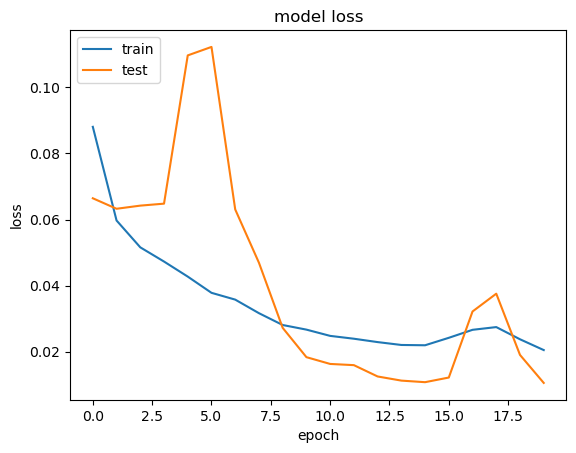

<Figure size 640x480 with 0 Axes>

In [11]:
create_plots(history)